In [1]:
#Documentation : http://docs.scipy.org/doc/scipy/reference/sparse.html
"""
Sparse matrices can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power.
Advantages of the CSR format

        efficient arithmetic operations CSR + CSR, CSR * CSR, etc.
        efficient row slicing
        fast matrix vector products
Disadvantages of the CSR format

        slow column slicing operations (consider CSC)
        changes to the sparsity structure are expensive (consider LIL or DOK)
"""
from scipy.sparse import csr_matrix
from scipy.sparse import dia_matrix
import scipy.sparse.linalg as spl

import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Signal processing on graph

### Introduction

First, we would like to thank John D Cook for its [short introduction](https://www.johndcook.com/blog/2016/02/09/fourier-transform-of-a-function-on-a-graph/) on Fourier series on graph, and of course [Pierre Vandergheynst](https://scholar.google.ch/citations?user=1p9NOFEAAAAJ&hl=fr), for its interesting courses and its contributions to this field.

### Fourier series

Fourier series properties can be analyzed within various mathenatical framework. One of them is related to the Laplacian operator.

We recall that the Laplacian operator, sometimes written $\nabla \cdot \nabla$, $\nabla^2$ or $\Delta$, where $\nabla$ can be written $\left( \frac{\partial}{\partial x_0}, \frac{\partial}{\partial x_1}, \dots \frac{\partial}{\partial x_{n-1}} \right)$ and the laplacian operator applied to a function $f$ reads $\Delta f = \sum_{i=0}^{n-1} \frac{\partial f}{\partial x_i^2}$.

It is interesting to notice that the trigonometric polynomial that defines the (separable) Fourier series basis elements are eigenfunctions for the laplacian operators over euclidean spaces:

lets define $\delta_{nF}(x) = e^{2 \pi j nFx}$

And
\begin{align}
  \frac{\partial \delta_{nF}}{\partial x} (x) &= \frac{\partial  e^{2 \pi j nFx}}{\partial x} \\
  &= 2 \pi j nF e^{2 \pi j nFx} \\
\end{align}

And
\begin{align}
  \frac{\partial \delta_{nF}}{\partial x^2} (x) &=  -(2\pi nF)^2 e^{2 \pi j nFx} \\
  &= -(2\pi nF)^2 \delta_{nF}\\
  &= \lambda \delta_{nF}
\end{align}

Moreover, eigenfunctions of the laplacian can also be defined for functions on finite domains (Bessel functions for radially symmetric domain like disks and sphere)

### Fourier series on graph

Following the definition seen in the previous section, we can see that on cane define eigenfunctions of laplacian operator on various domain including graph, for instance in our case, where we consider our laplacian operator $L$ as: $L=D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ where $A$ is the adjacency matrix and $D$ is the degree matrix of the graph.

Hopefully, in an undirected graph, $L$ is a symmetric positive semi definite matrix, hence is diagonalizable in an orthonornmal basis. A function that is defined by a set of values, one per node can then be analyzed over this graph, using eigenvectors of the graph ordered by the norm of their corresponding eigenvalues.

On can then consider that projection of the function over the lower eigenvectors corresponds to low "frequencies", and conversely, the high "frequencies" are obtained when projecting the function over the highest eigenvalues


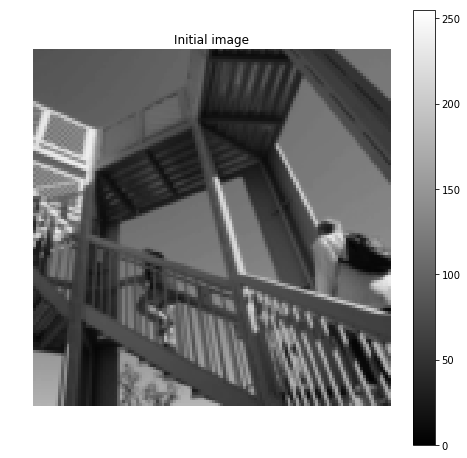

In [45]:
# Import an image, and downsize it in order to make the problem numerically tractable
im=sc.misc.imresize(sc.misc.ascent(),size=(128,128))
im=im.astype(np.float32)
plt.imshow(im, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
figsize(8,8)
plt.axis("off")
colorbar()       # displays the color bar close to the image
title('Initial image')

In [52]:
#Threshold: valued used to forbid disconnected nodes in the graph of the image
thresh= 1e-4

#Sigma of the gaussian distance metric
sigma = 2
sigmaSquare = sigma**2

#Size of the stencil
stenSize = 4

#will contain the value of the edges
data=[]
rowIdx=[]
colIdx=[]

"""
Now we are going to fill the graph matrix, neglecting small terms.
Distance are actually computed twice, this can be optimized
"""

for idxI in range(im.shape[0]):
  for idxJ in range(im.shape[1]):
    curPixIdx=idxI+im.shape[0]*idxJ
    for stenX in range(-stenSize,stenSize+1):
      for stenY in range(-stenSize,stenSize+1):
        stenIdxX = idxI+stenX
        stenIdxY = idxJ+stenY
        destPixIdx = stenIdxX+im.shape[0]*stenIdxY
        if (stenIdxX>=0)and(stenIdxX<im.shape[0])and\
          (stenIdxY>=0)and(stenIdxY<im.shape[1])and\
          ((stenIdxX!=idxI)and(stenIdxY!=idxJ)):
          dist = np.exp(-np.linalg.norm(im[idxI,idxJ]-im[stenIdxX,stenIdxY])**2/(2*sigmaSquare))
          dist=max(thresh,dist)
          data.append(dist)
          rowIdx.append(curPixIdx)
          colIdx.append(destPixIdx)

#Practical implementation using scipy support for sparse matrices
A = csr_matrix((np.array(data), (np.array(rowIdx), np.array(colIdx))), dtype=np.float32)

#Now the diagonal matrix
D = dia_matrix((np.array(A.sum(axis=0)),0),shape=A.shape)

#We can define the laplacian: L = D^-0.5 A D^-0.5
L = D.power(-0.5)*A*D.power(-0.5)

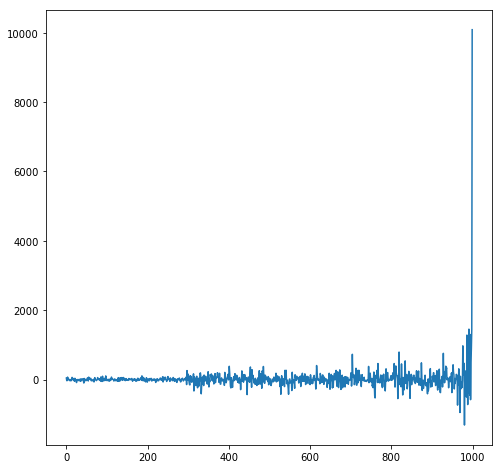

In [60]:
"""
Compute the eigendecomposition of the laplacian of the graph
"""

# Get the first 100 eigenvalues of L, a symmetric positive definite matrix
# See http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html and
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.svds.html
[w,X] = spl.eigsh(L, k=1000) #size is now [imsize,nbcomponent]

#Show the spectrum of the image, i.e its expression in the basis made of the first lapacian eigenvectors
spectrum = np.dot(X.T,im.reshape(im.size))
plt.plot(spectrum)

/home/tnotargi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


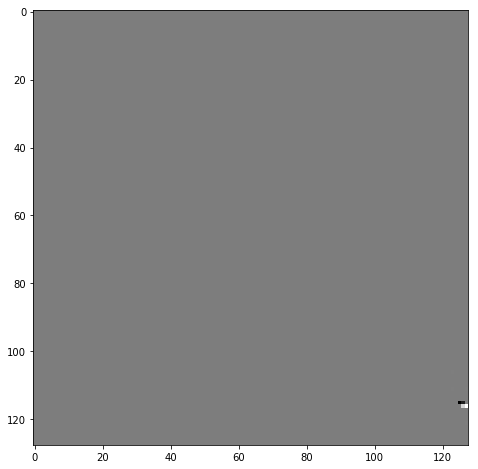

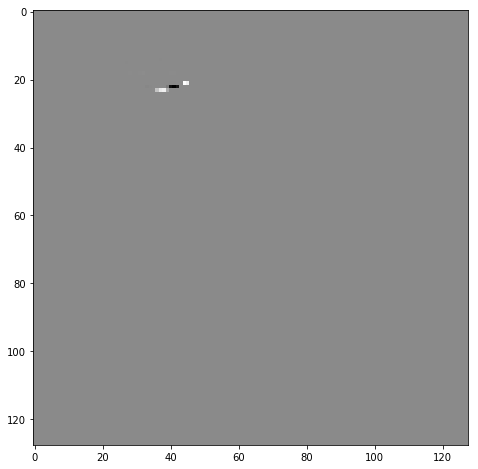

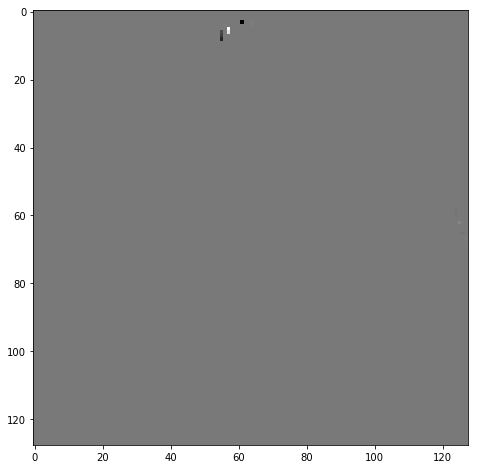

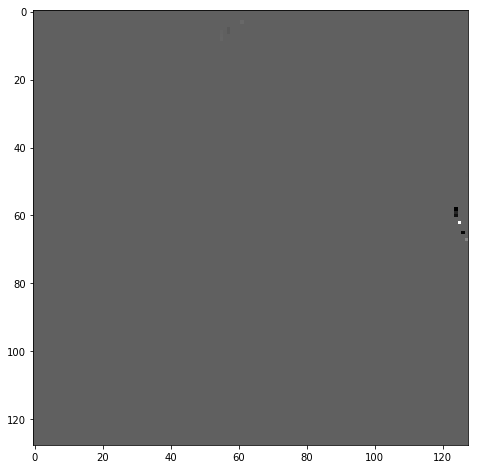

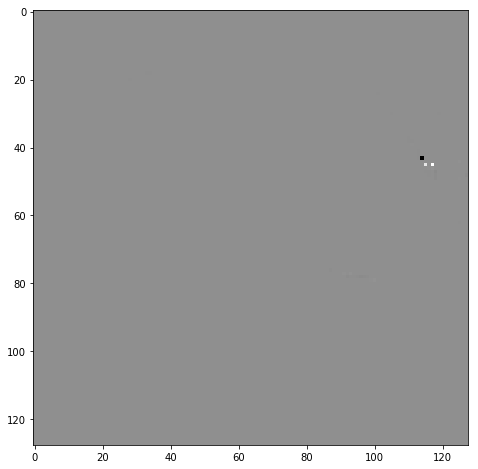

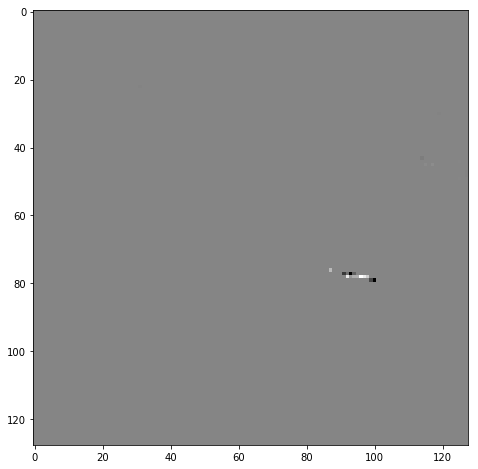

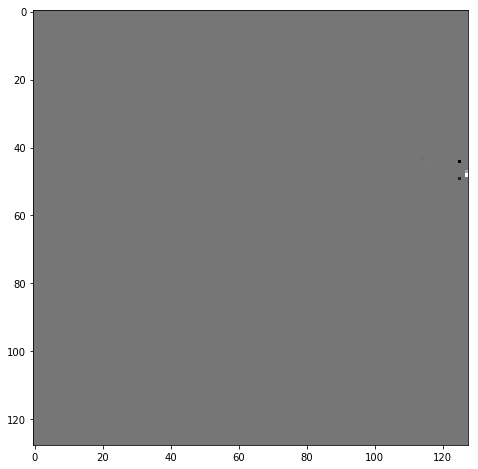

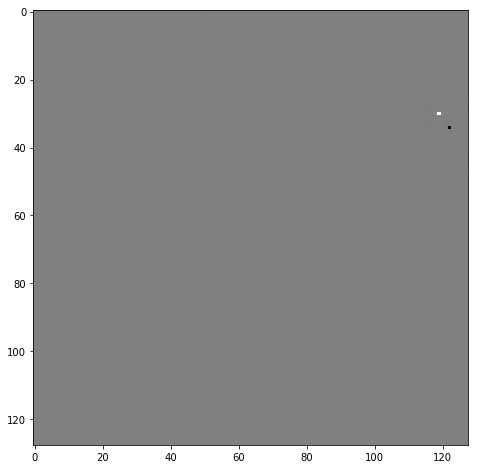

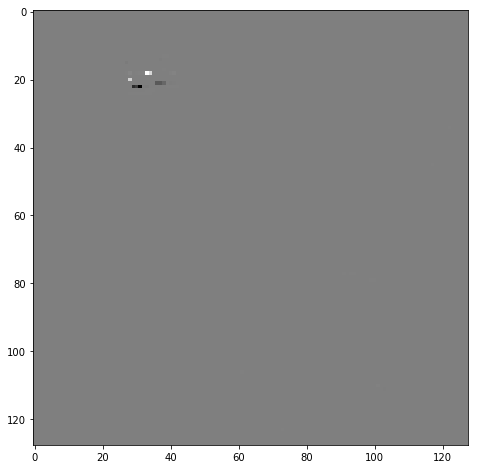

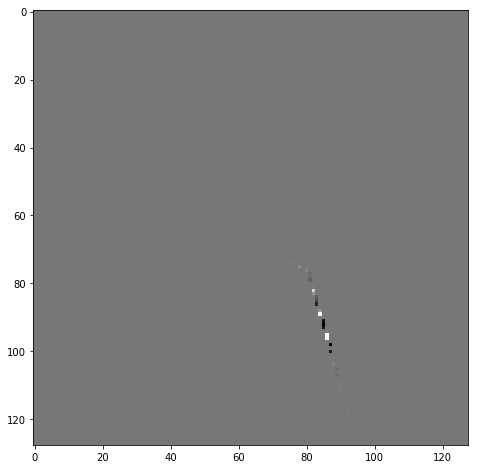

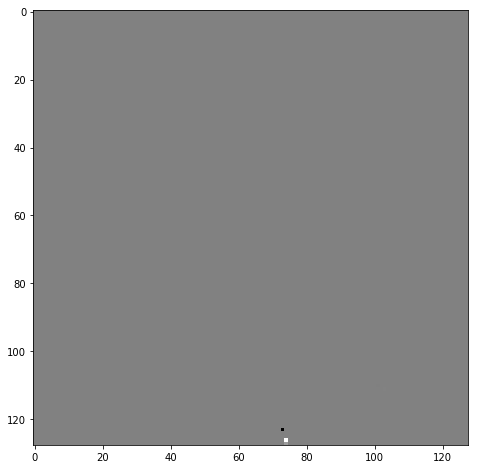

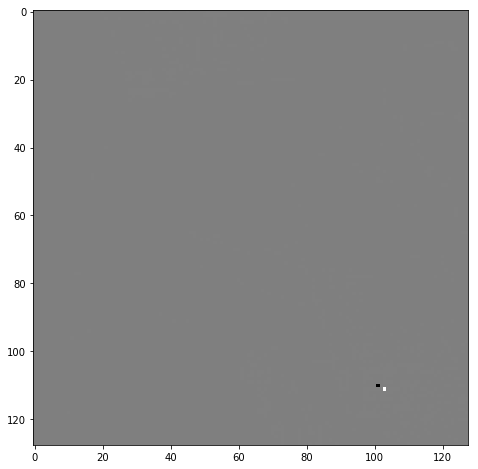

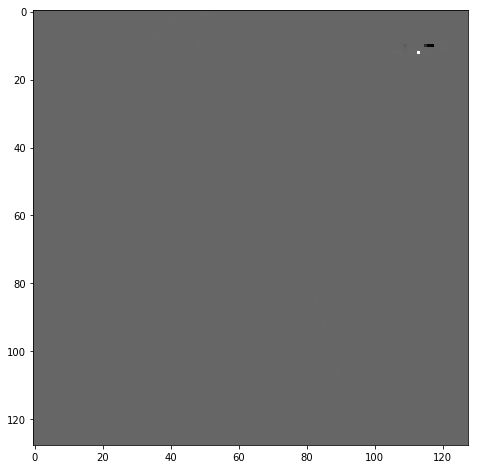

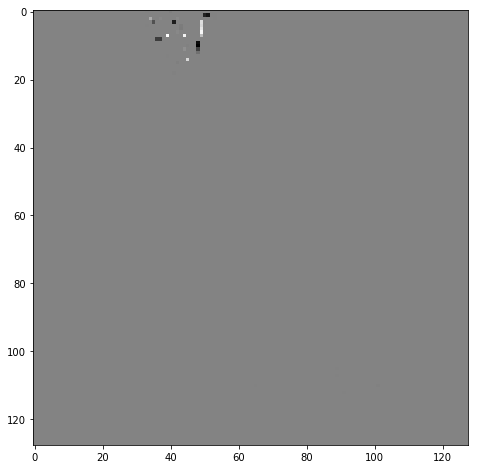

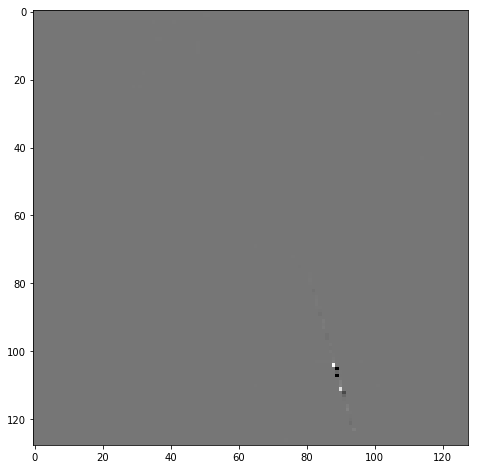

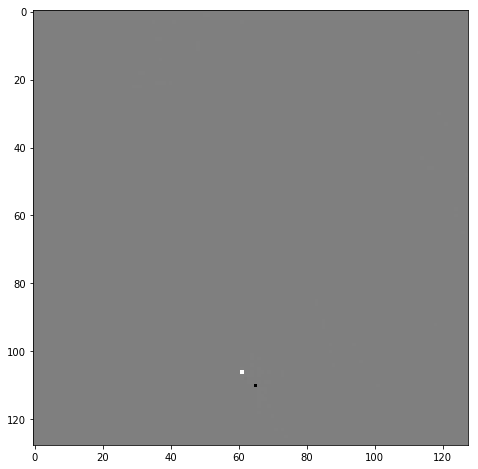

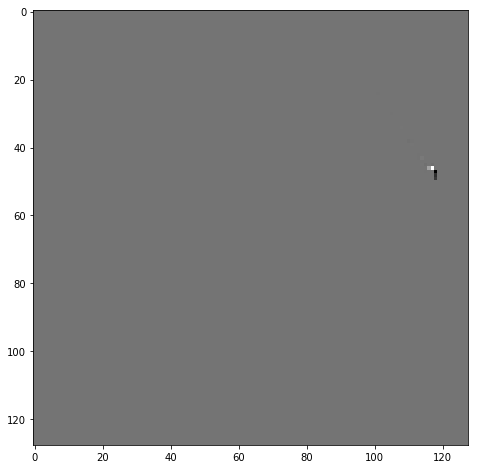

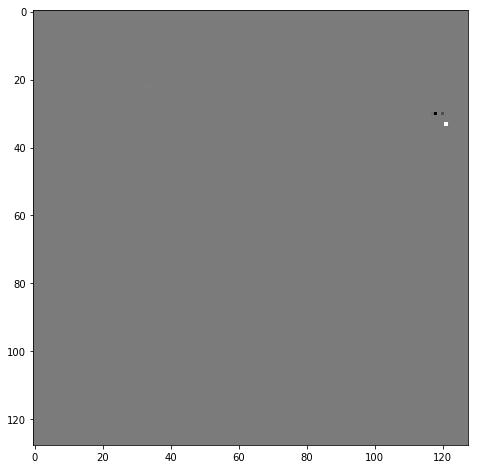

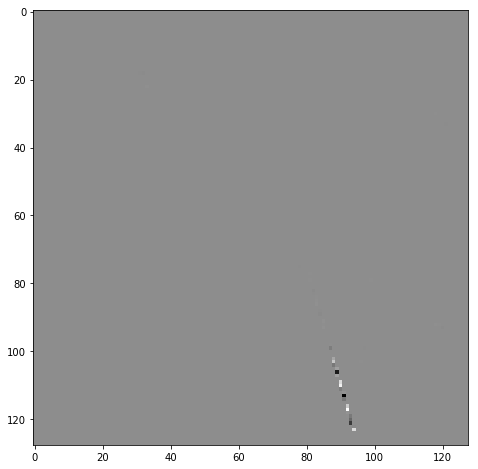

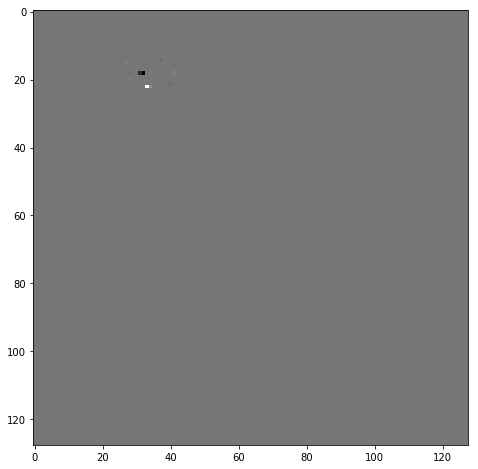

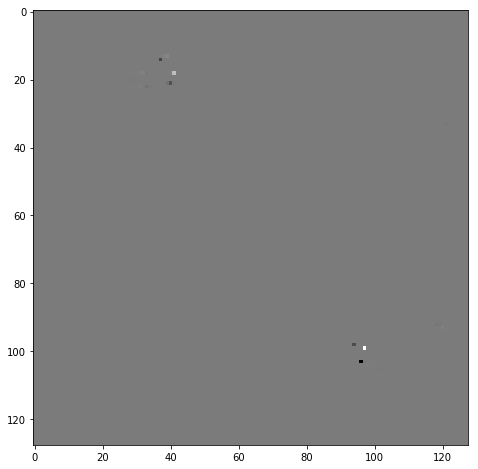

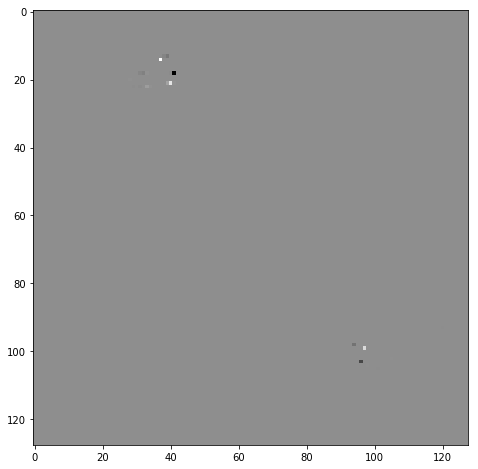

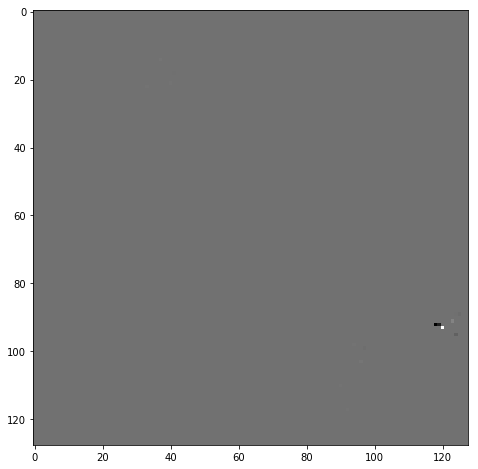

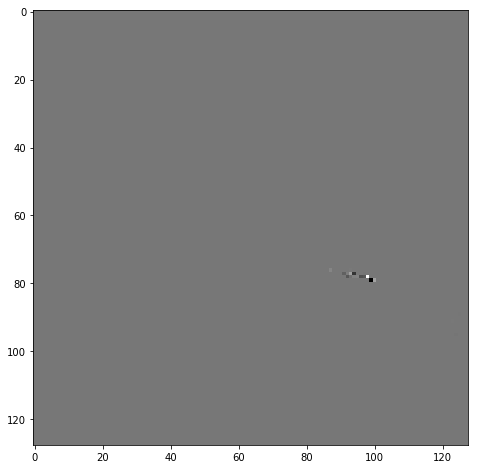

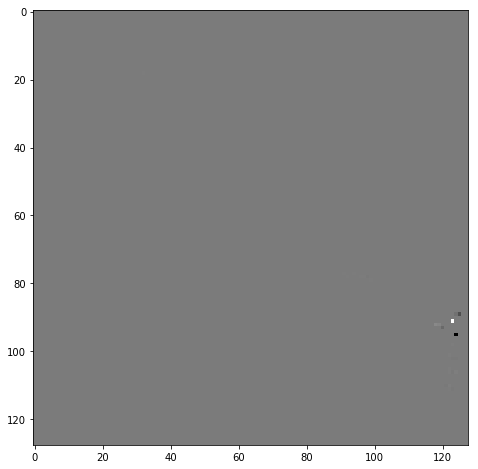

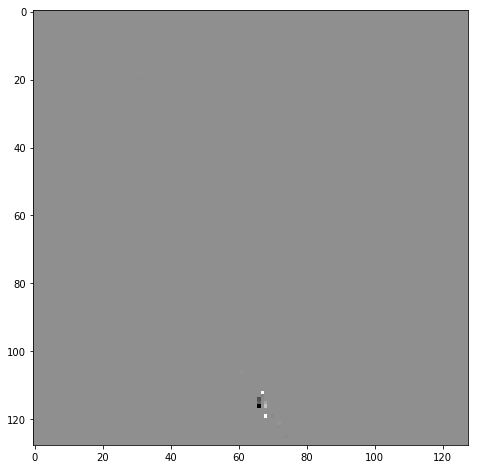

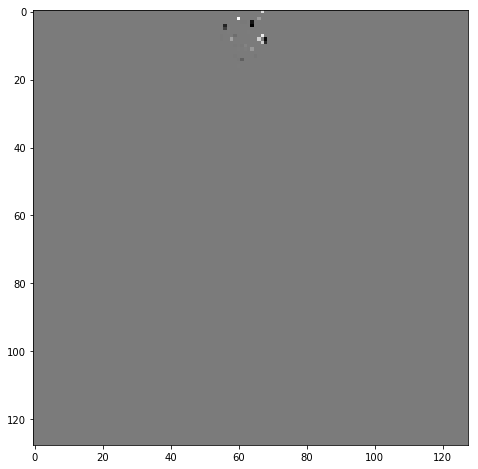

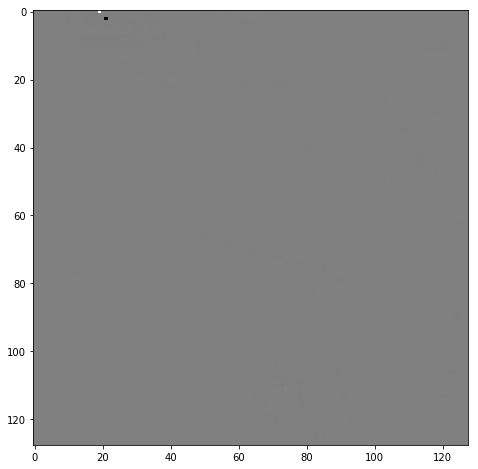

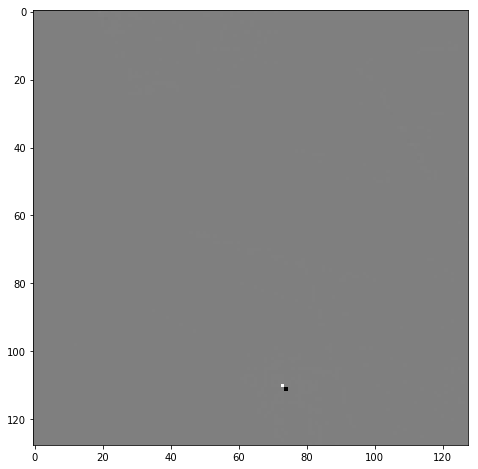

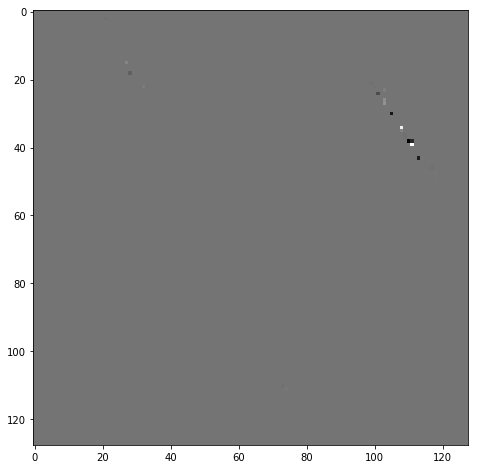

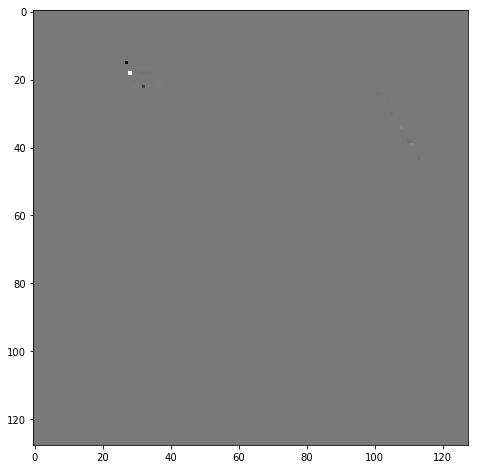

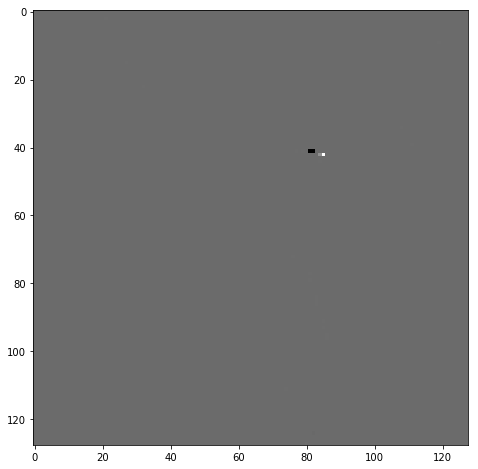

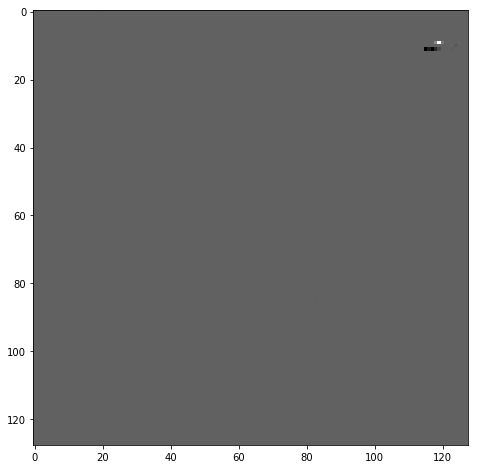

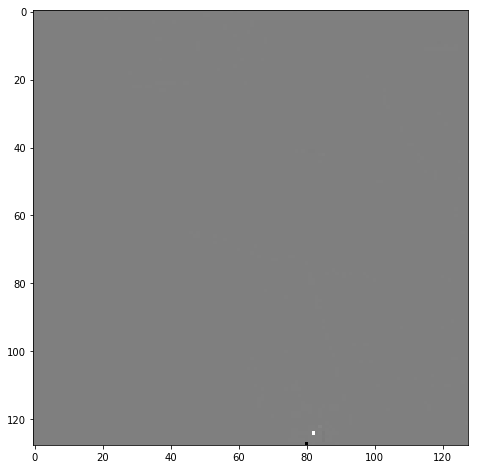

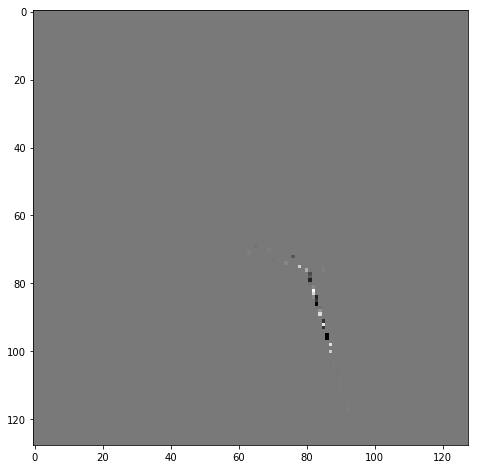

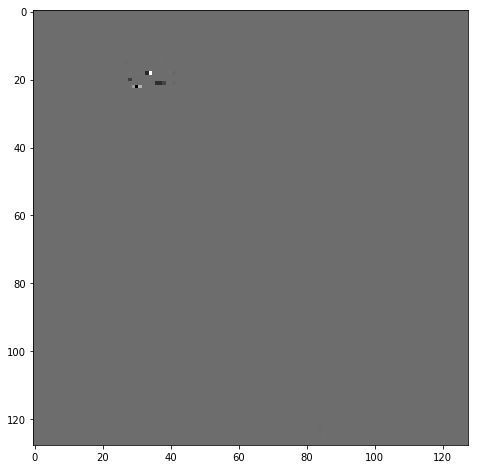

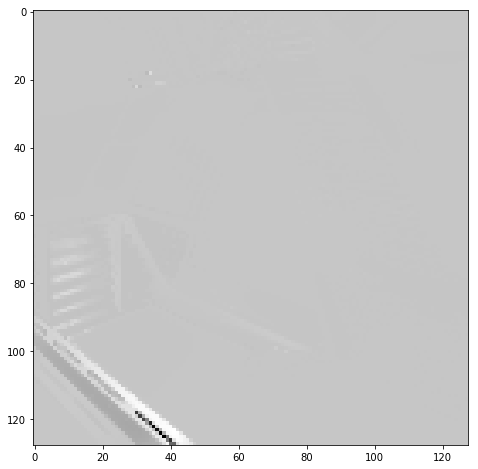

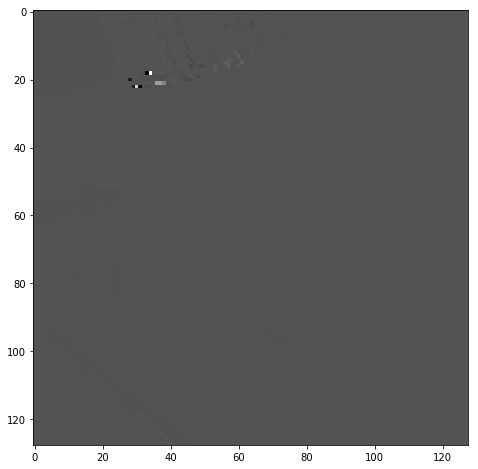

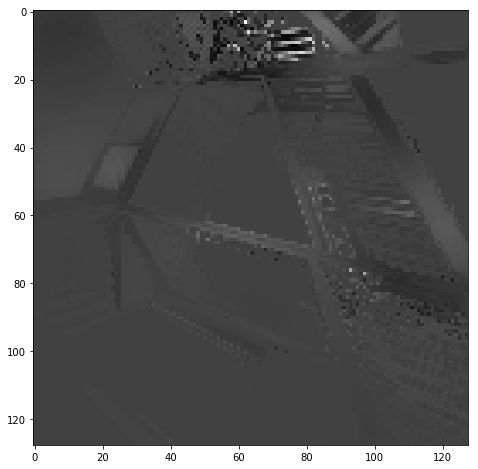

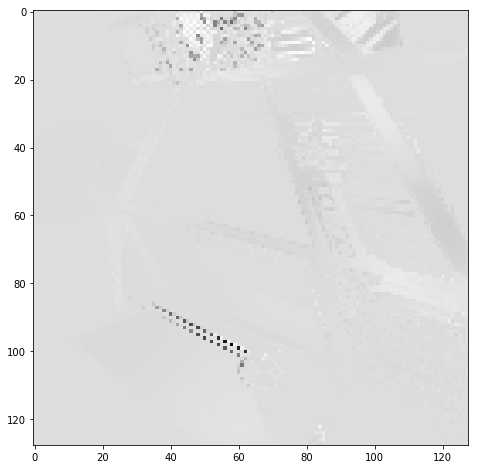

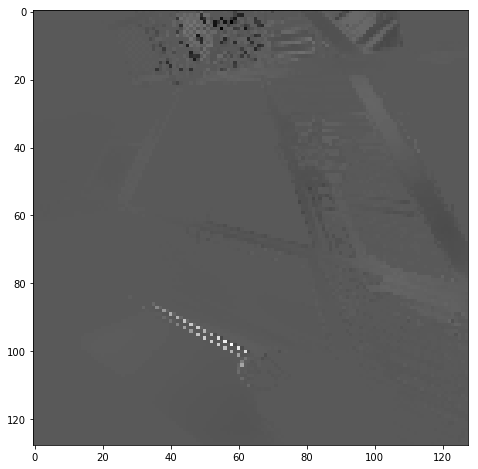

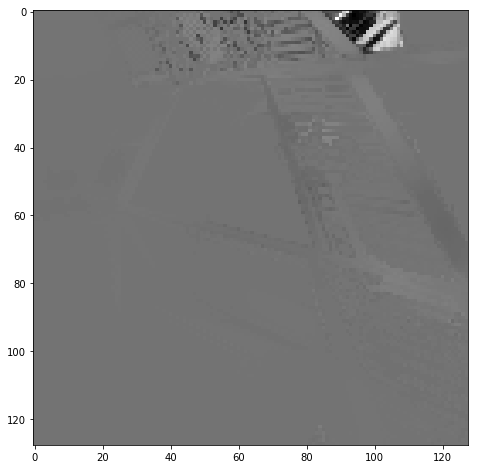

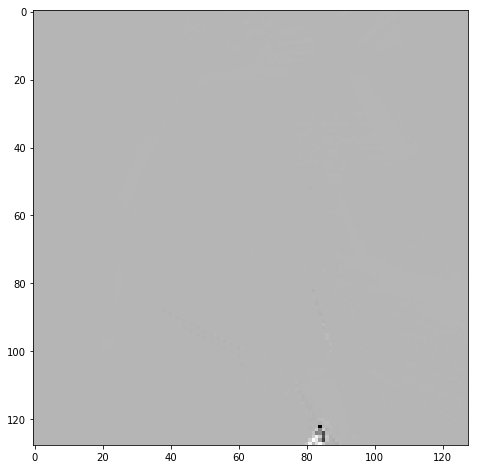

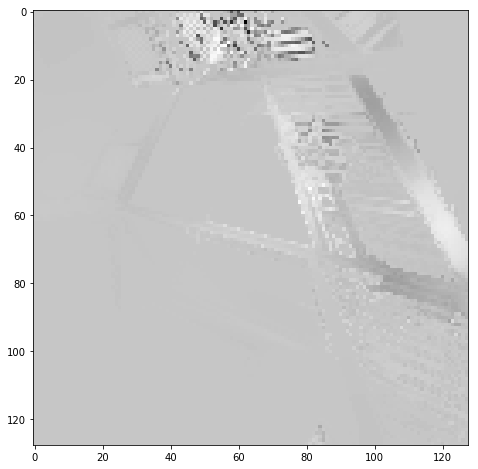

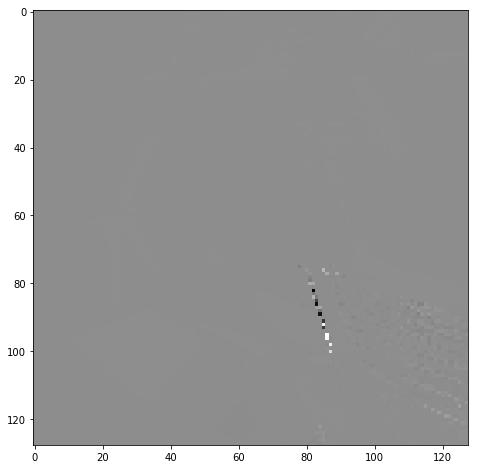

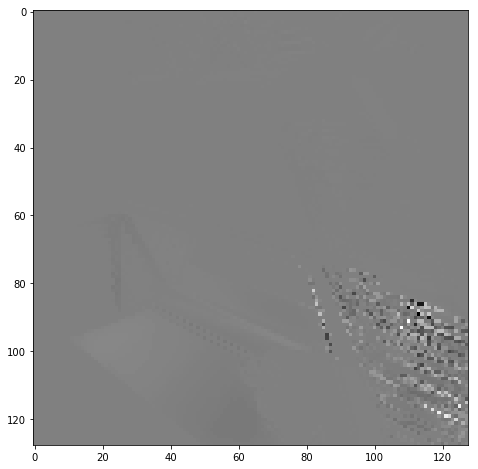

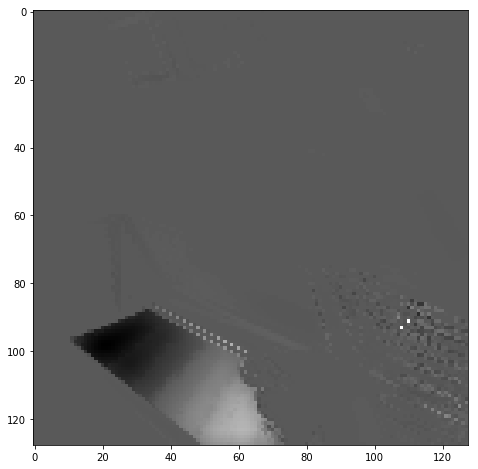

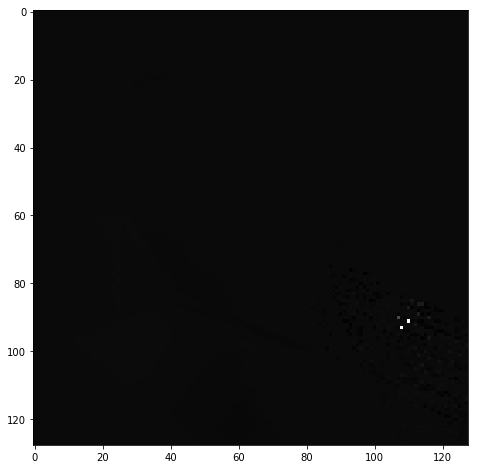

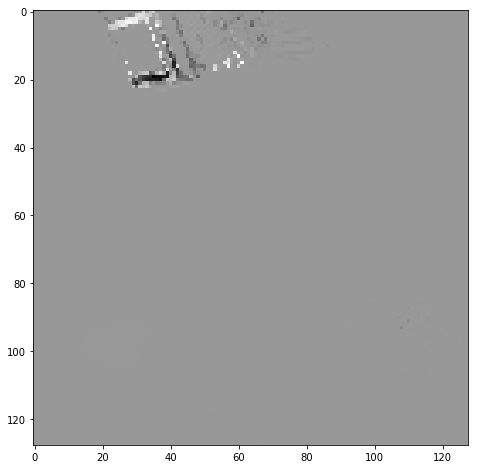

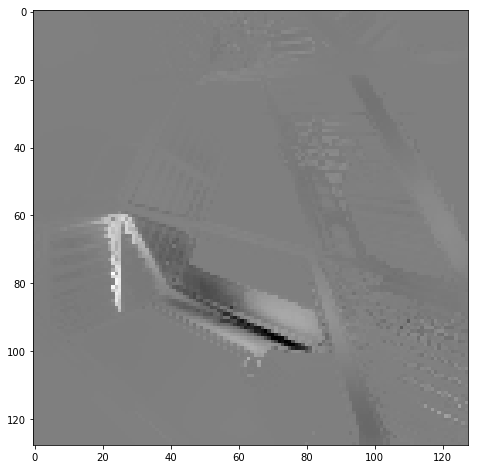

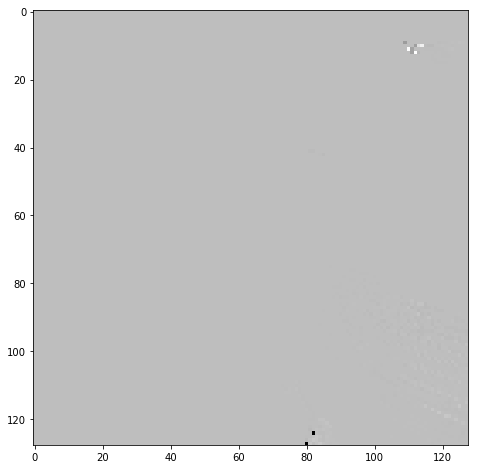

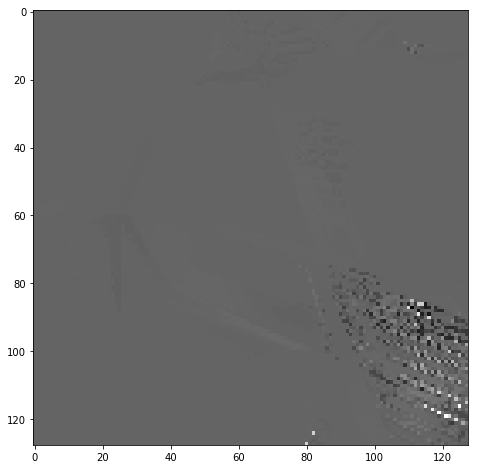

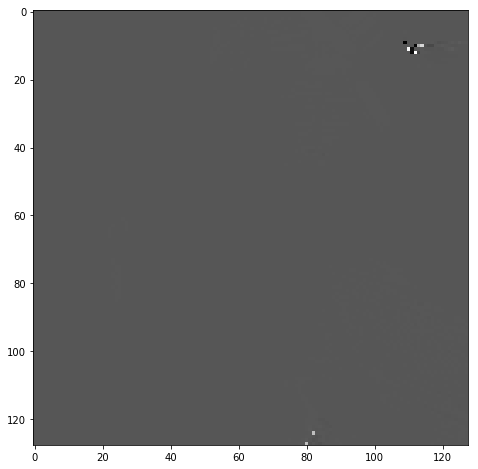

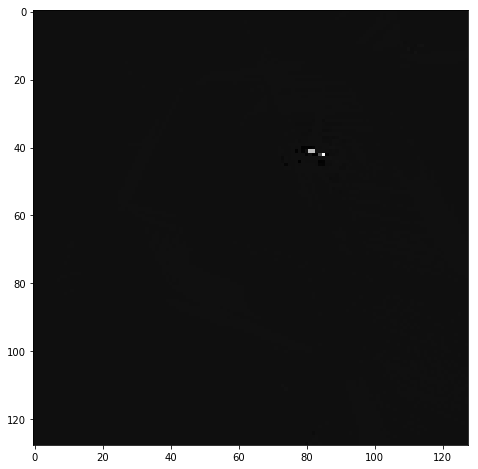

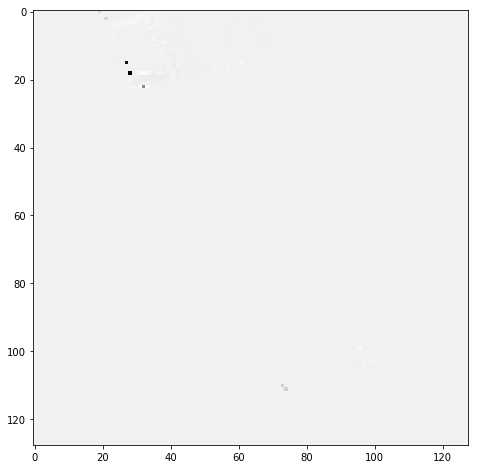

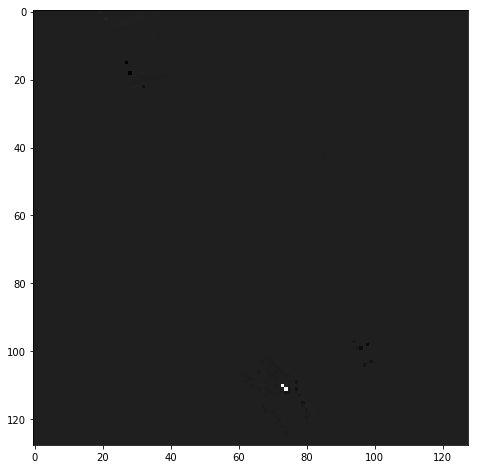

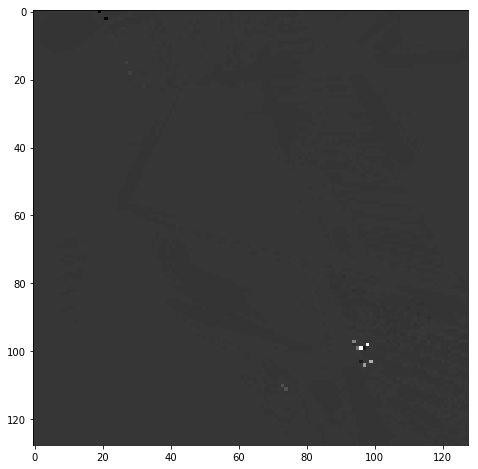

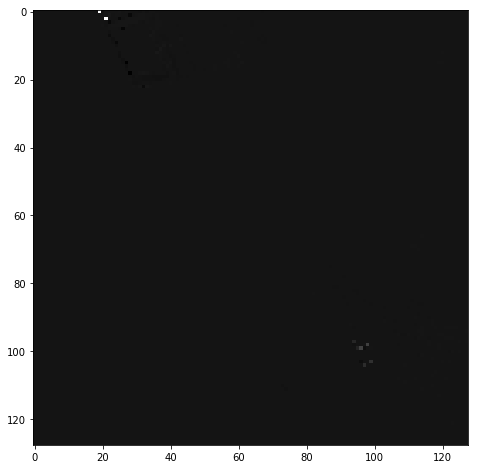

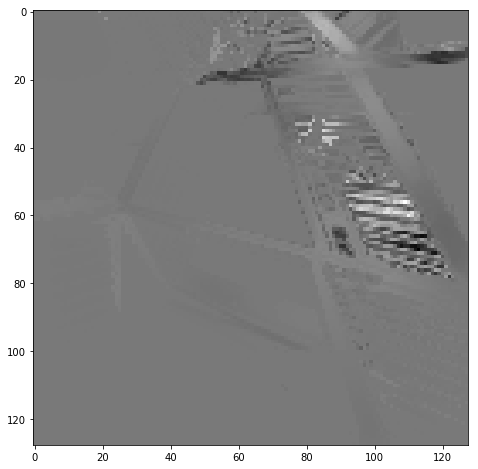

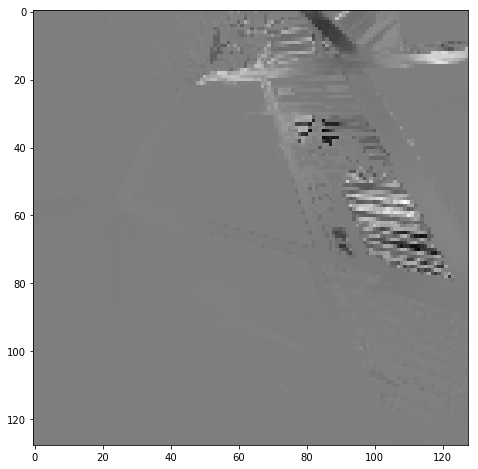

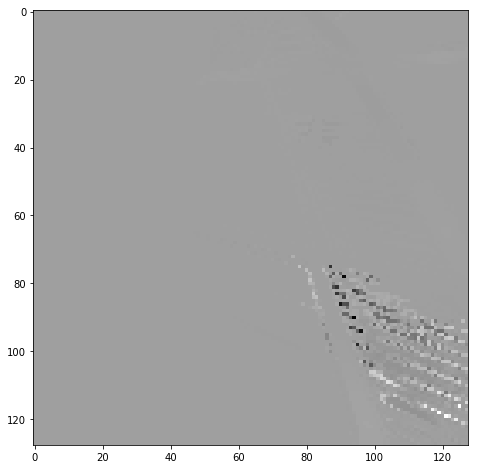

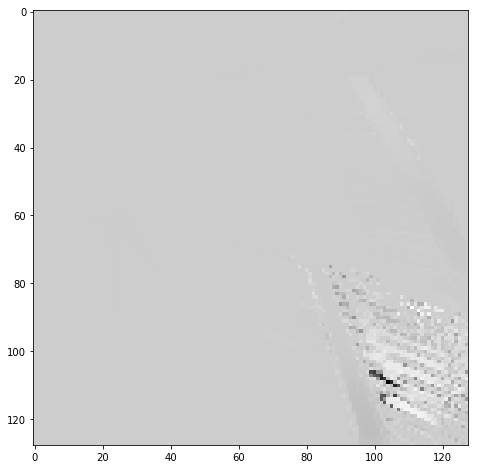

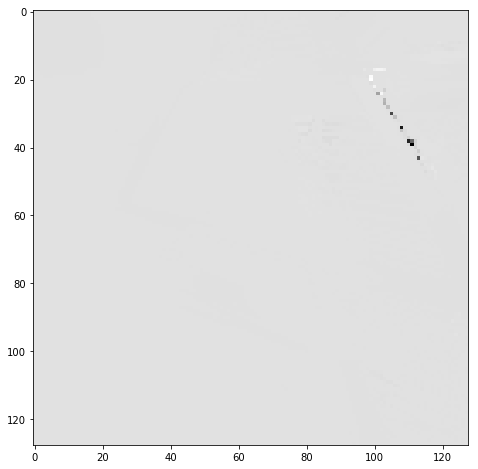

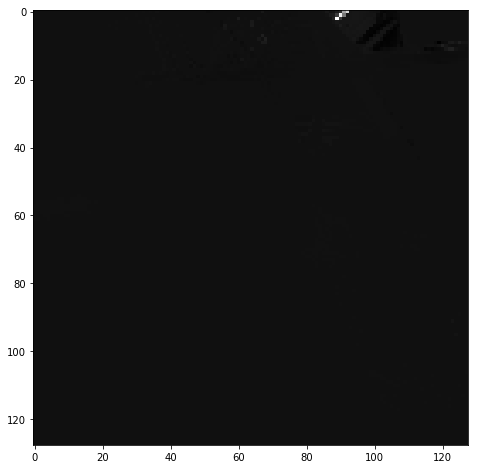

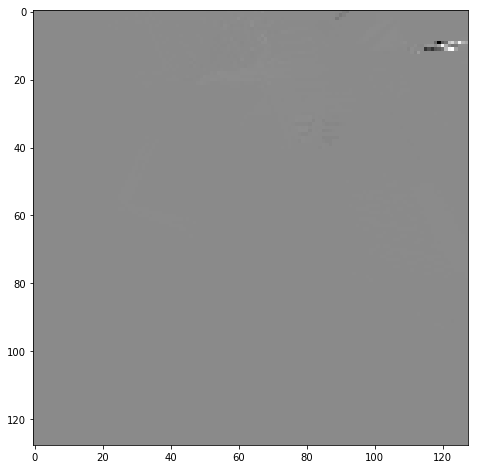

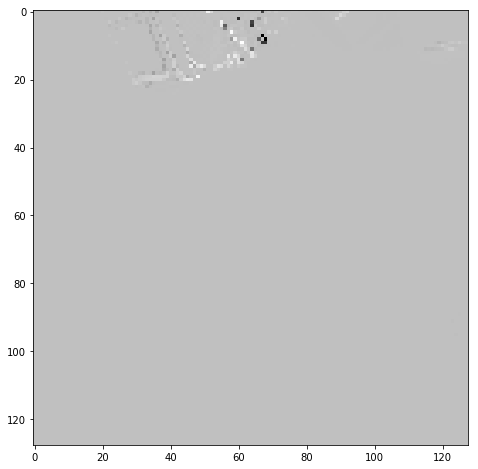

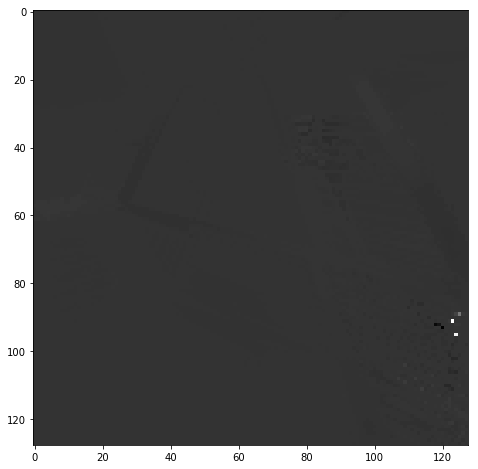

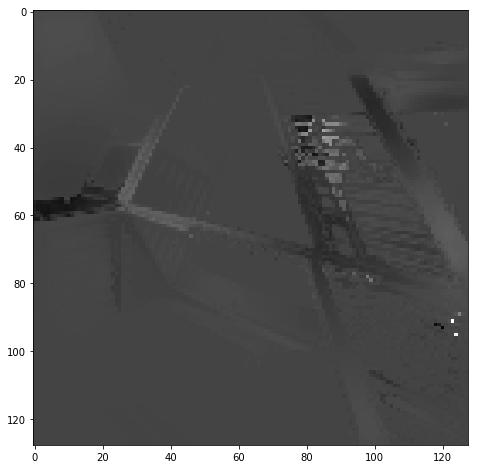

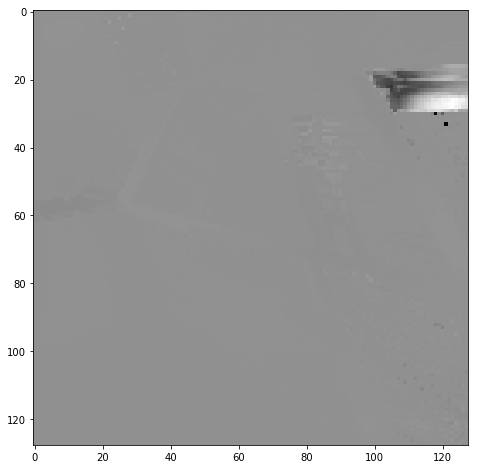

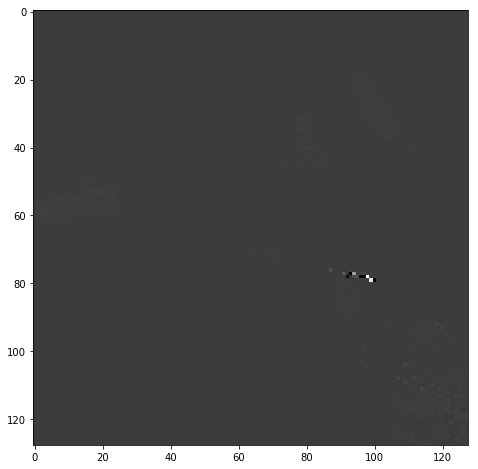

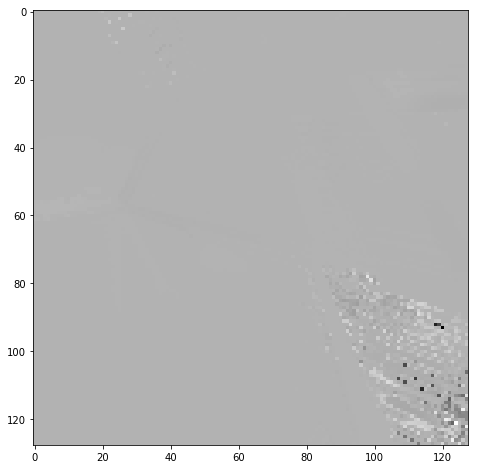

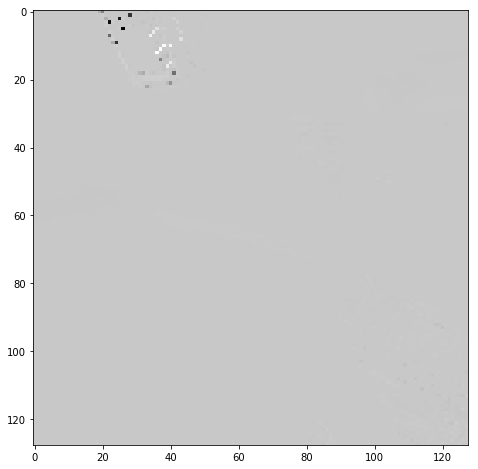

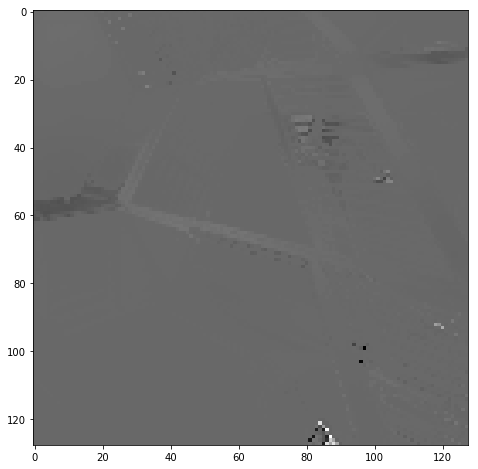

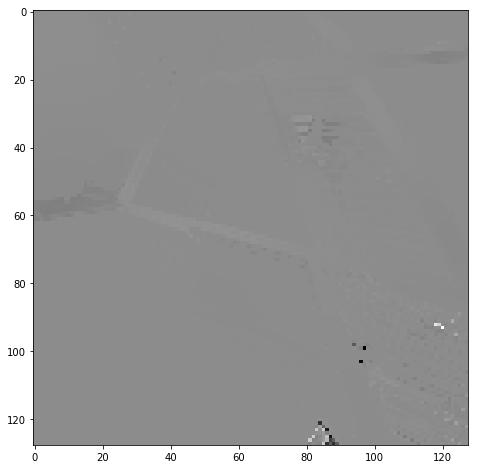

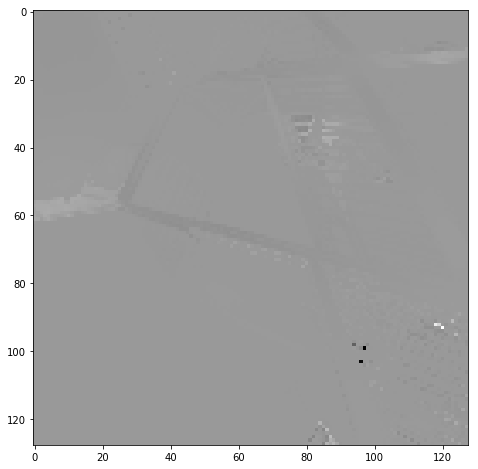

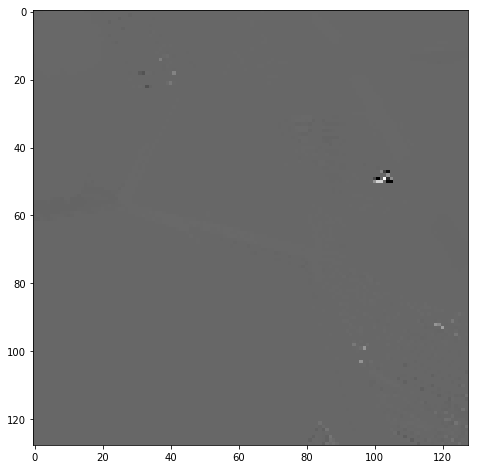

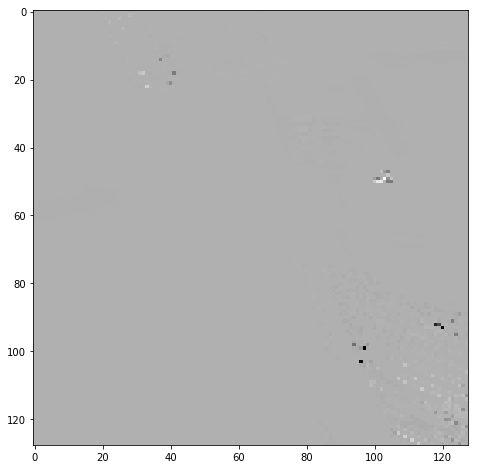

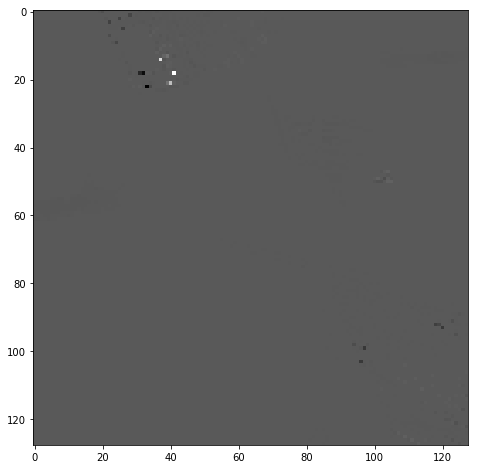

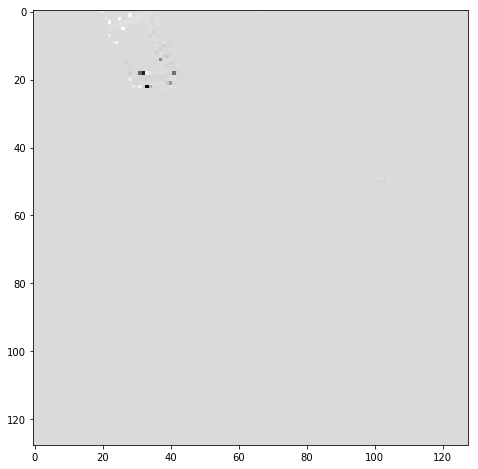

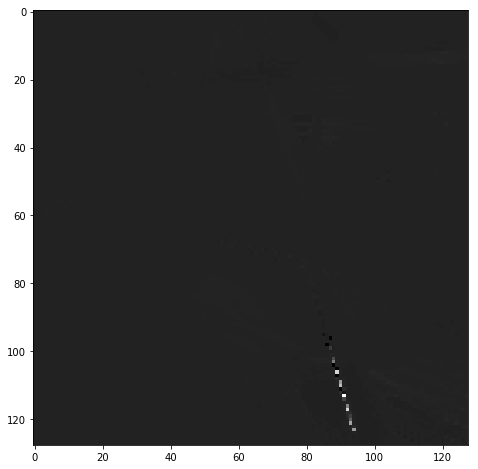

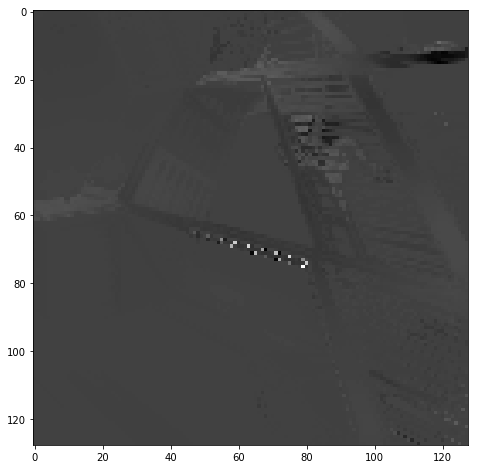

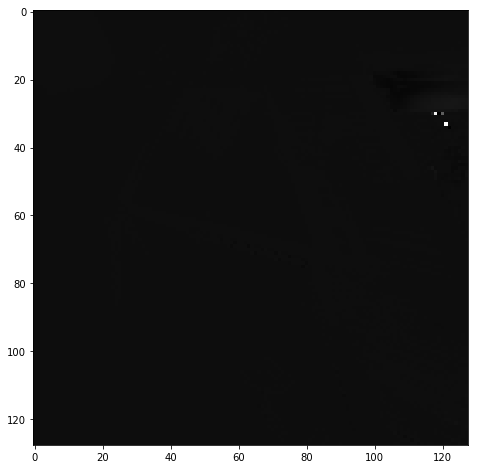

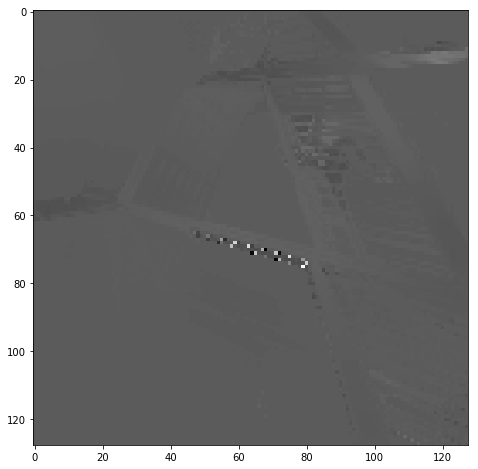

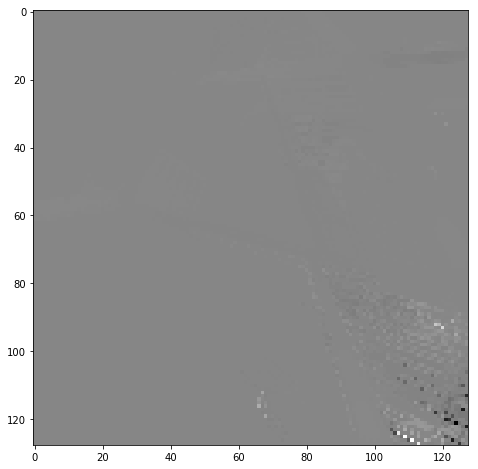

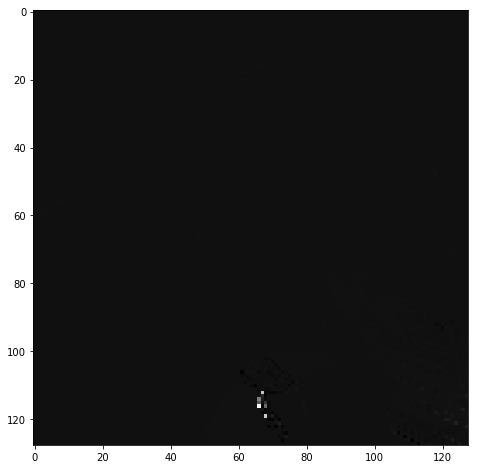

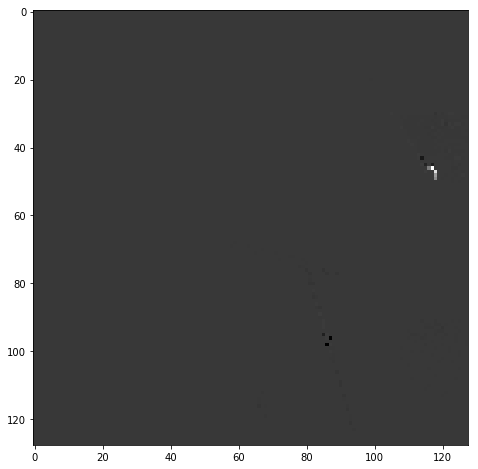

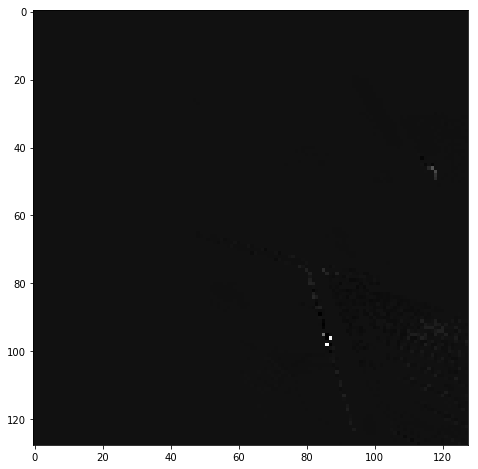

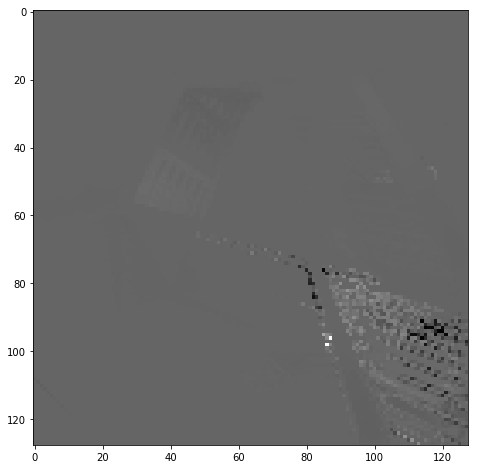

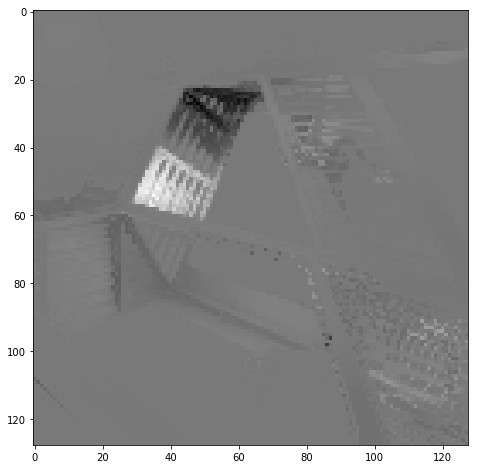

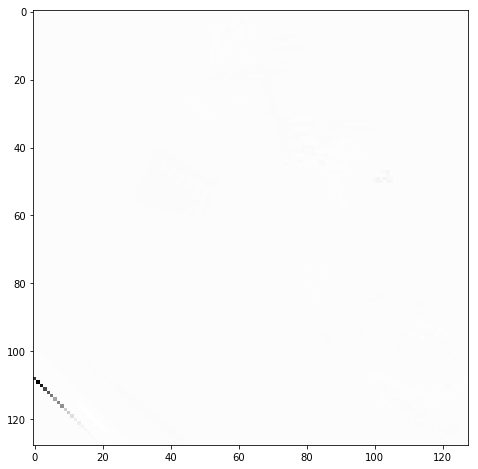

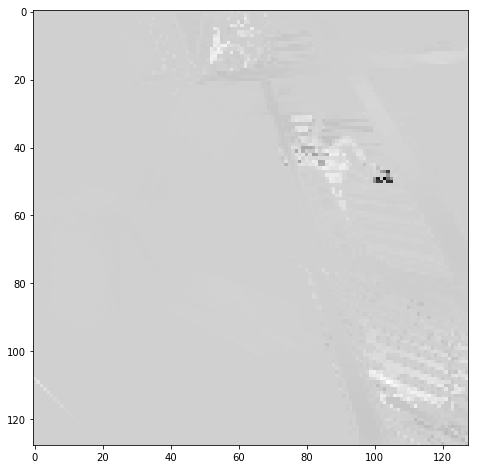

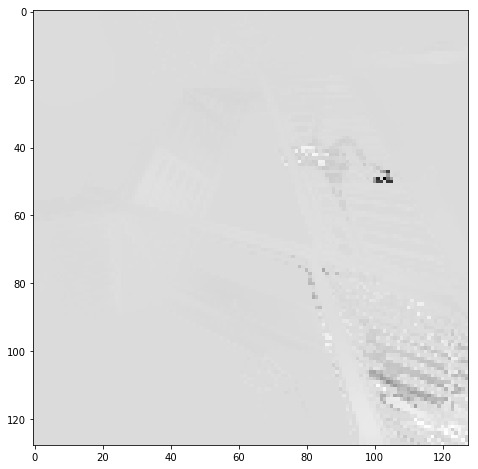

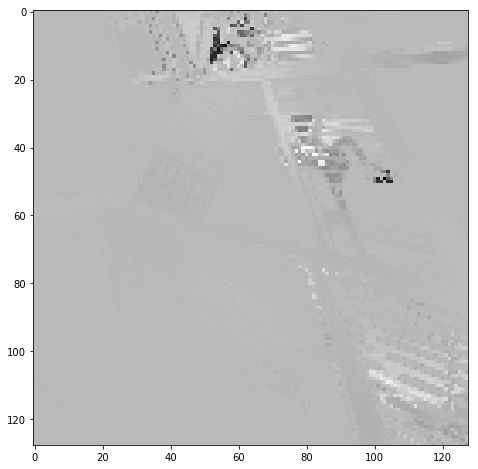

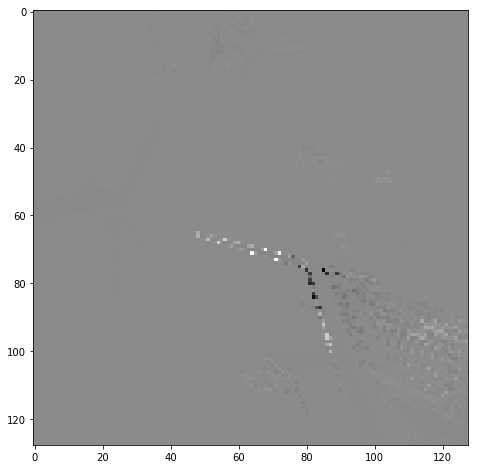

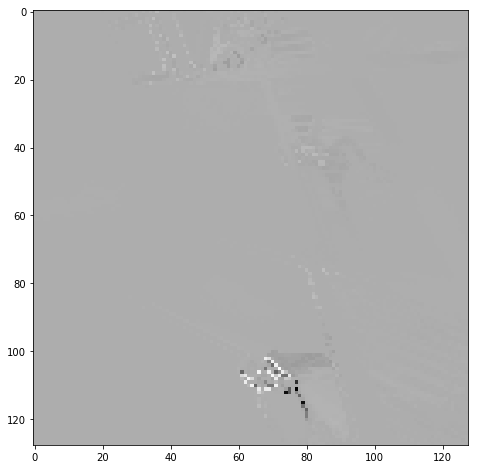

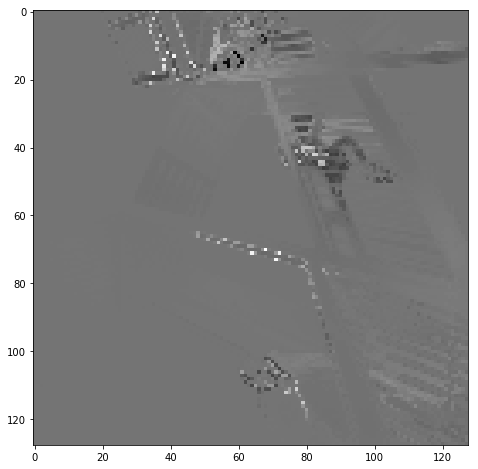

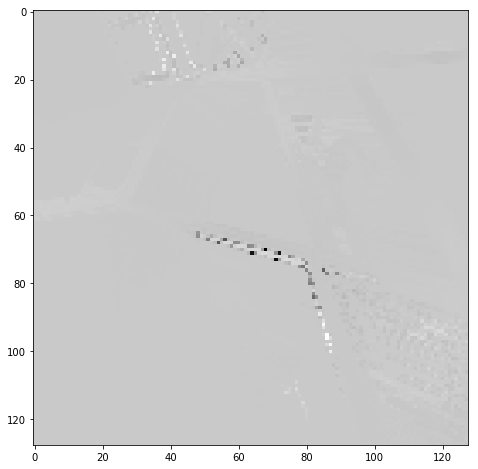

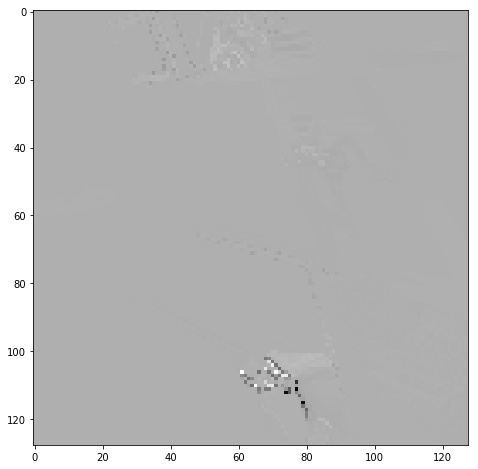

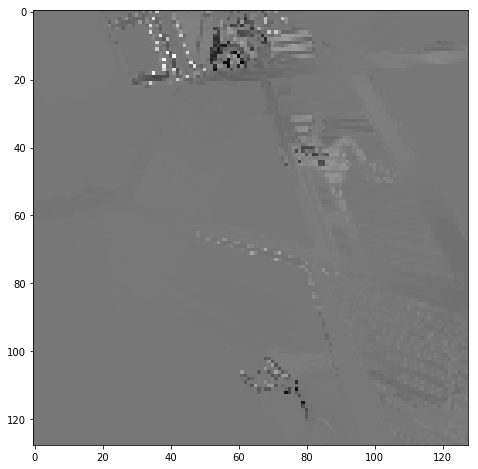

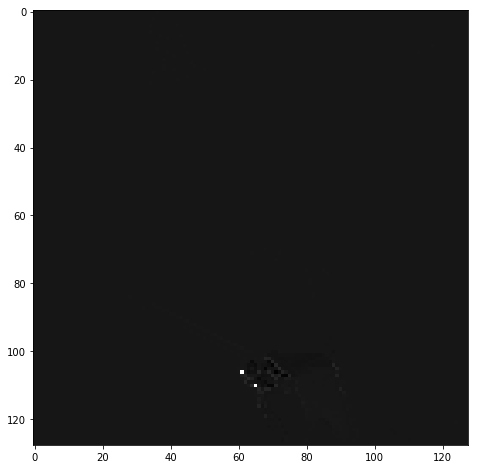

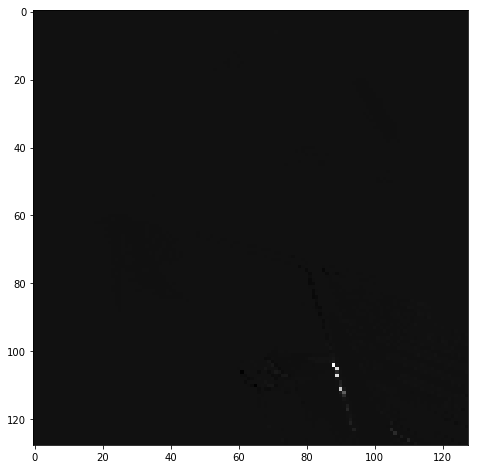

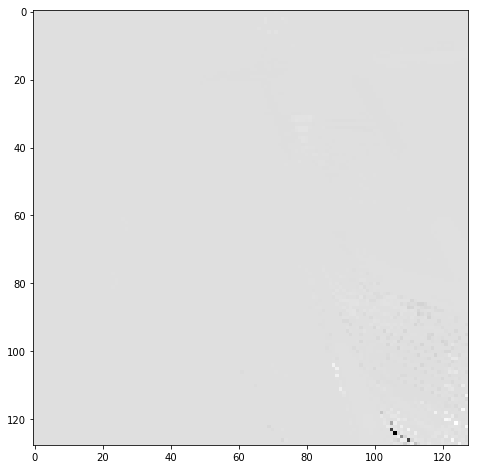

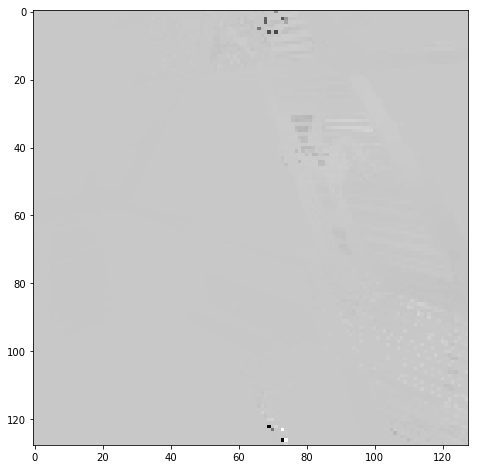

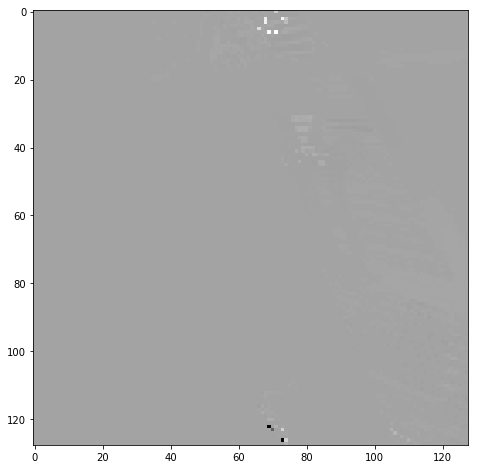

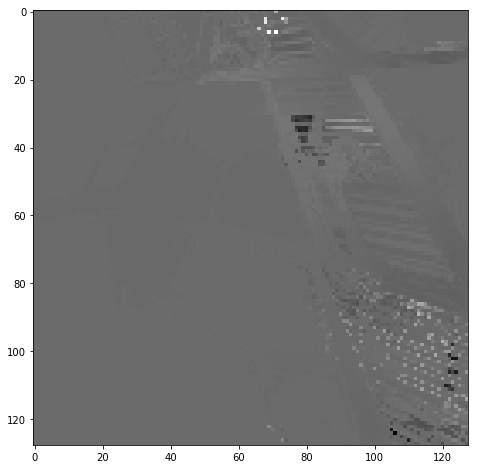

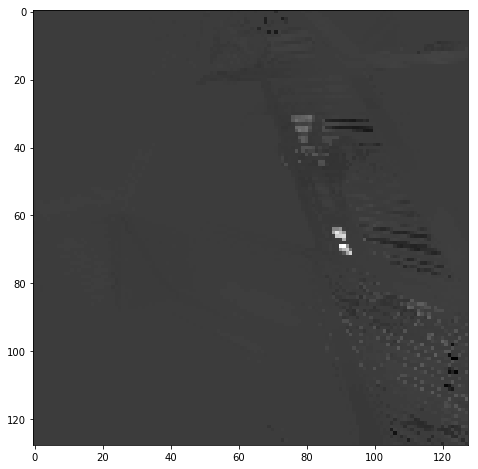

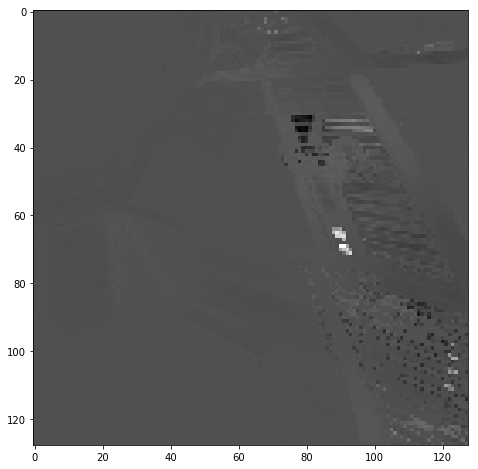

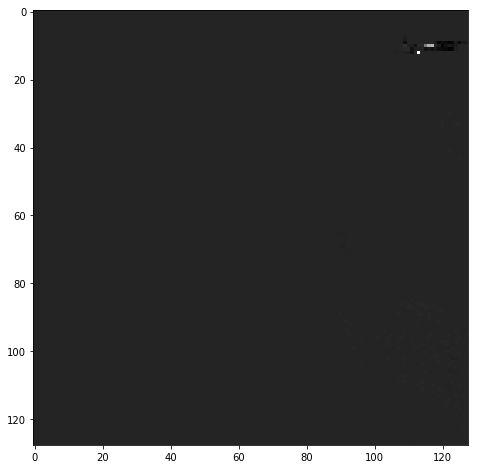

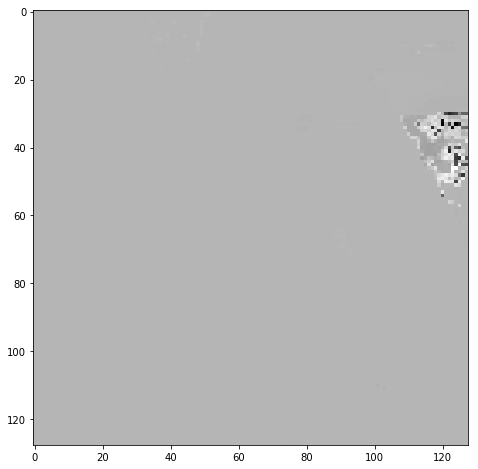

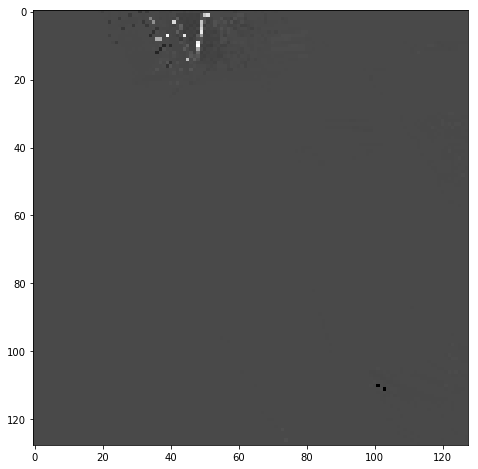

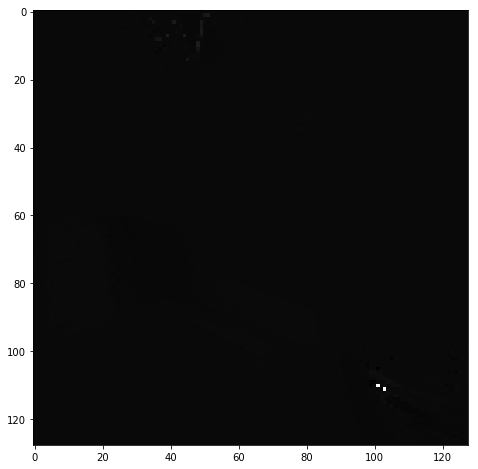

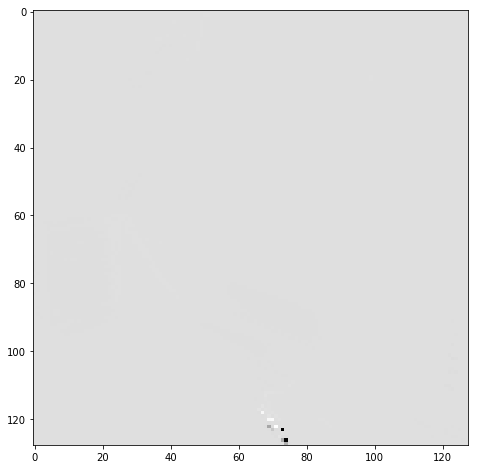

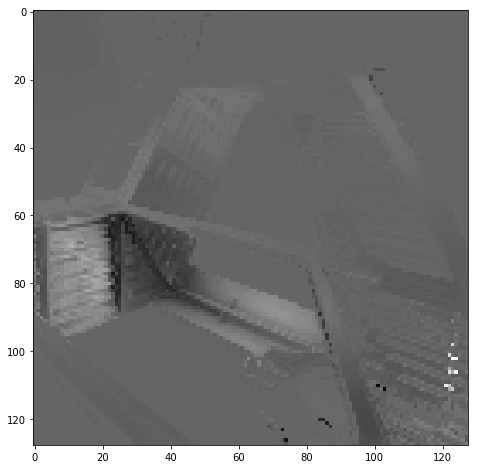

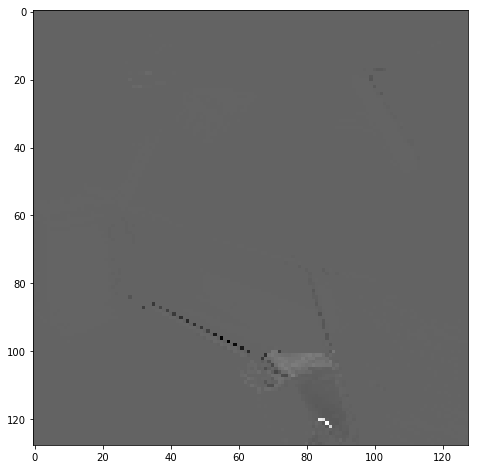

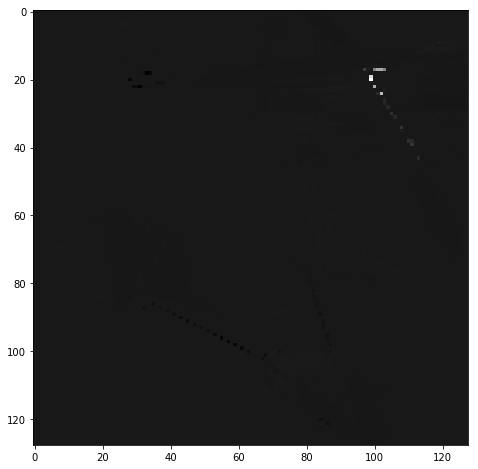

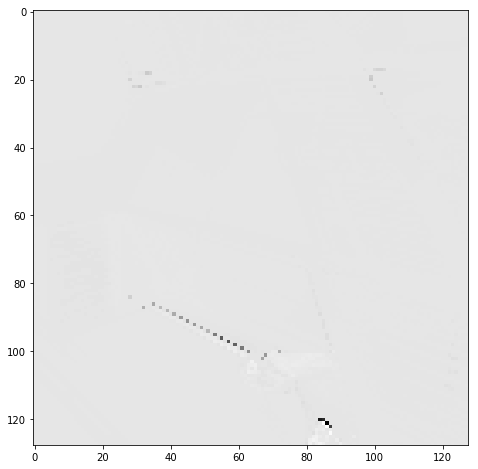

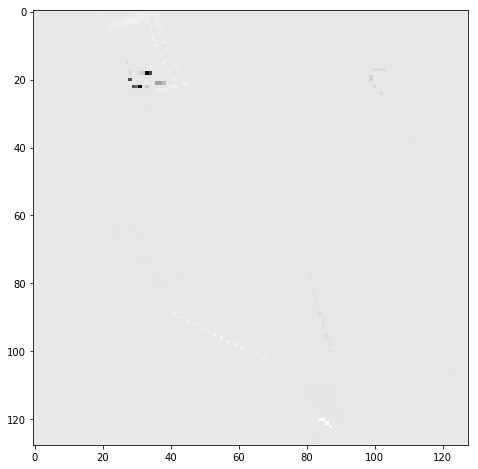

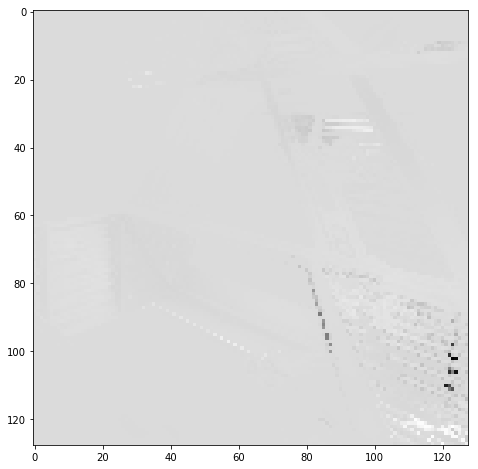

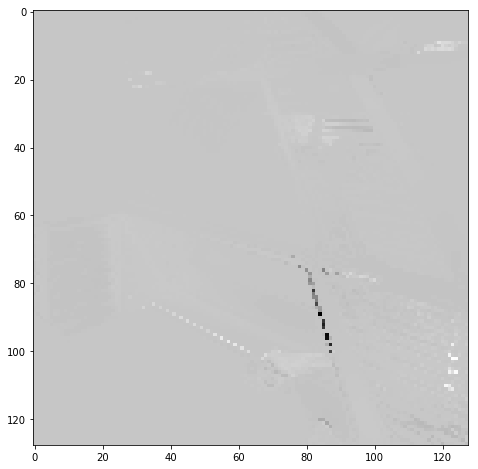

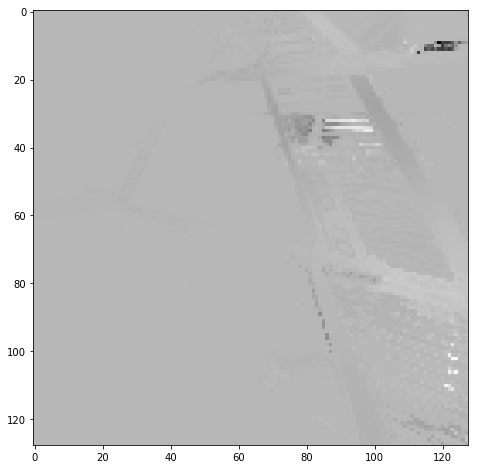

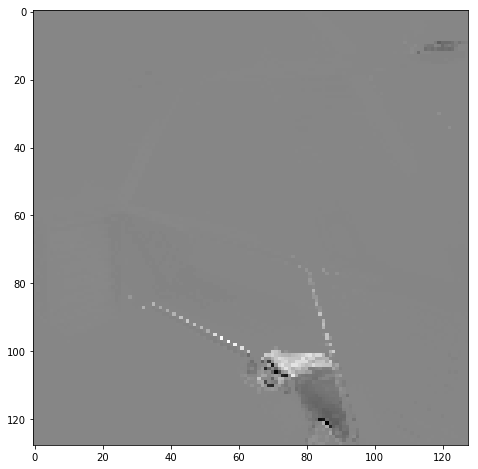

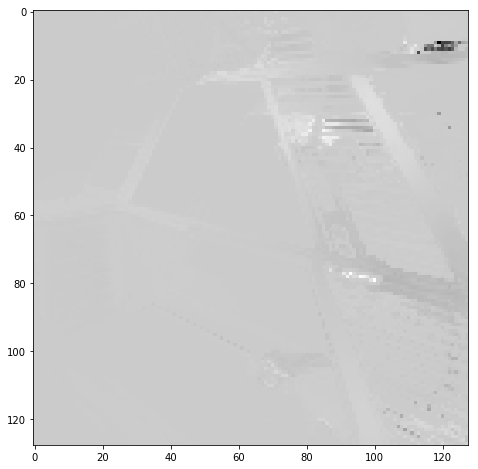

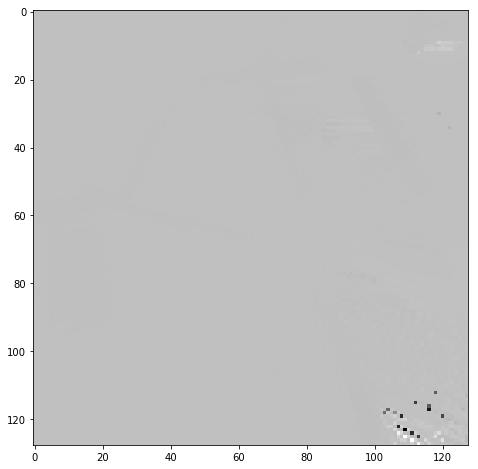

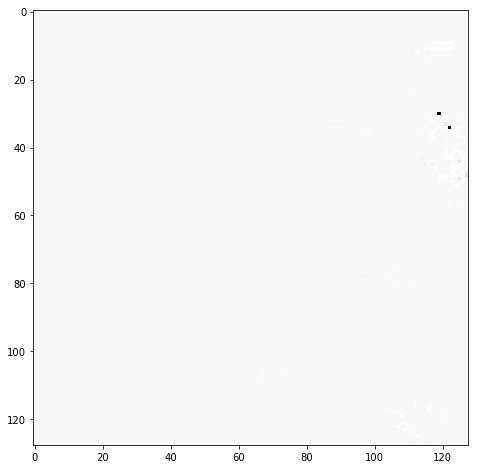

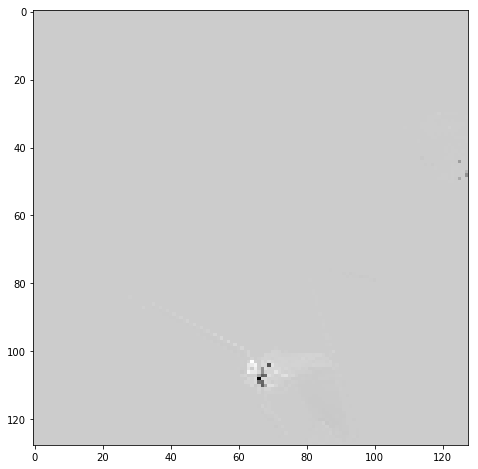

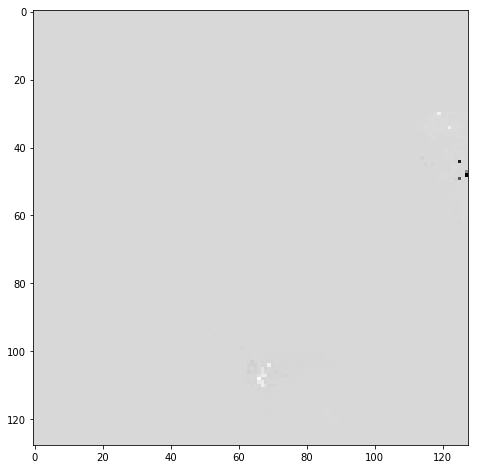

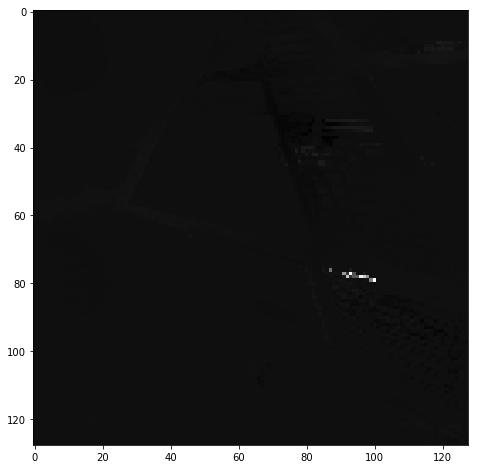

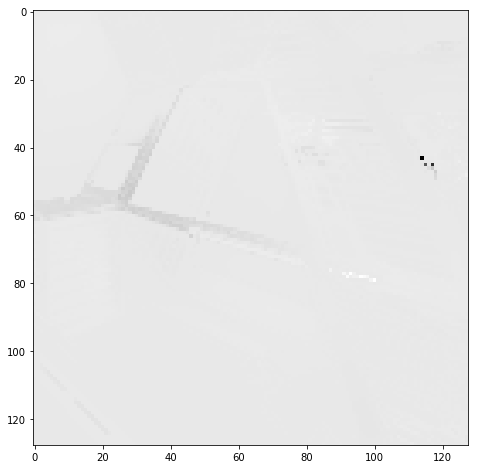

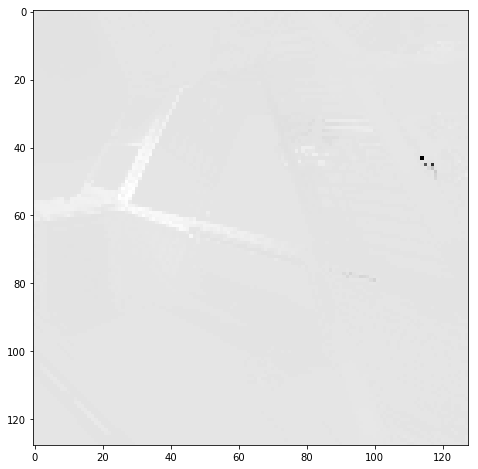

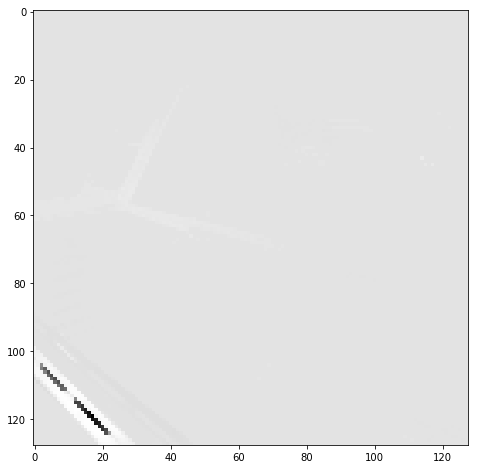

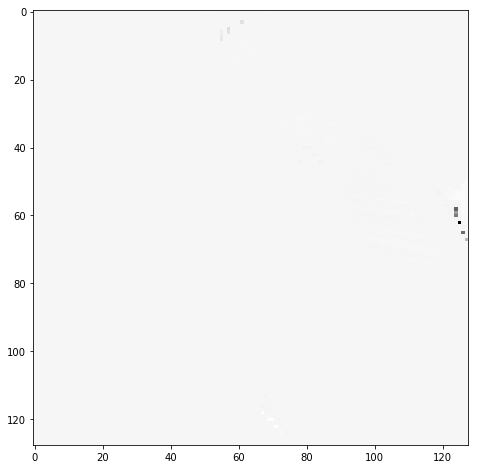

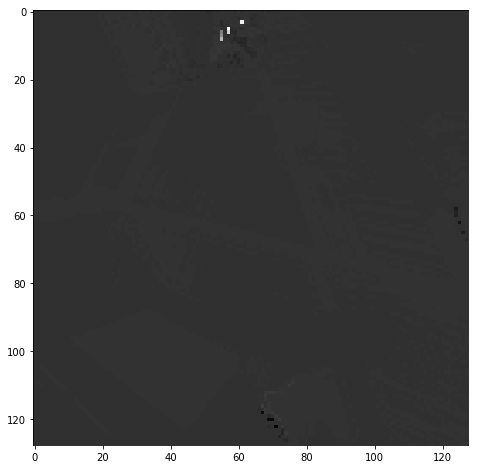

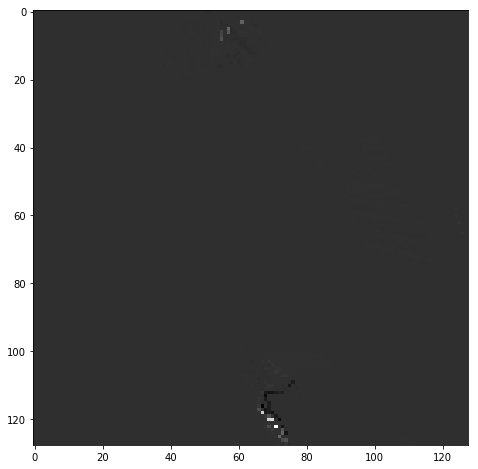

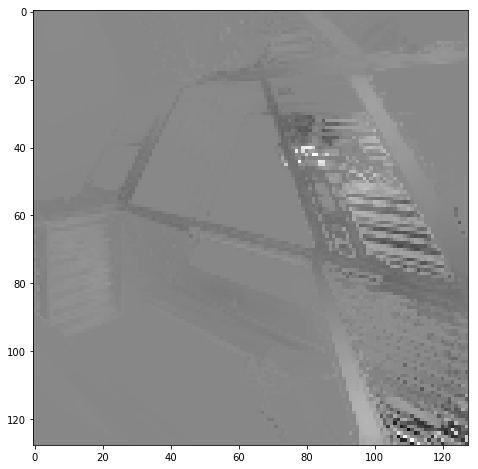

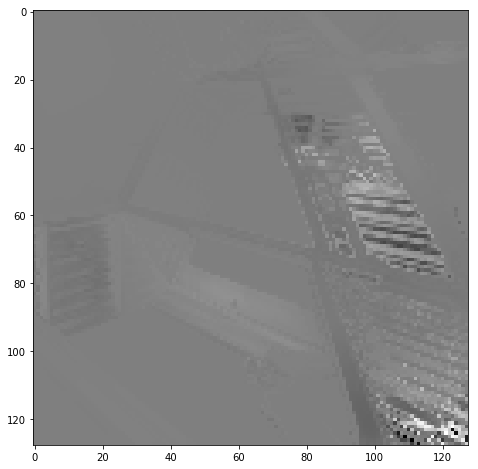

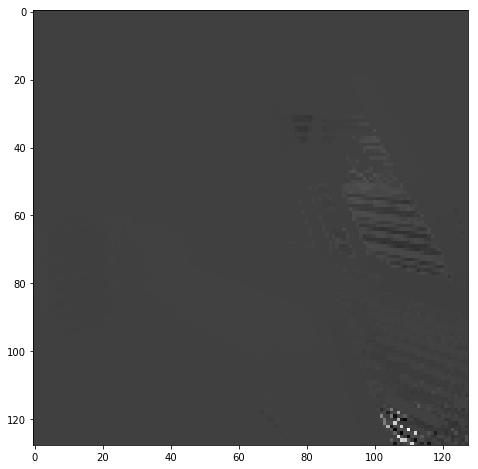

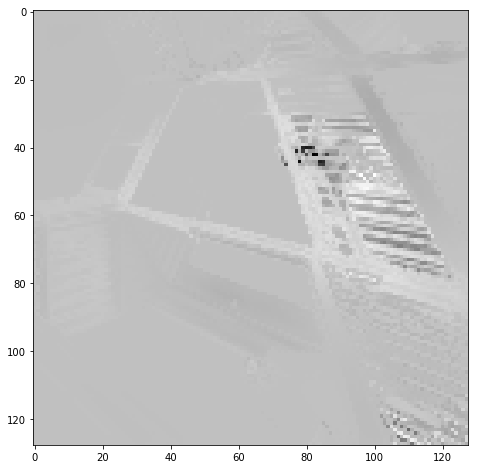

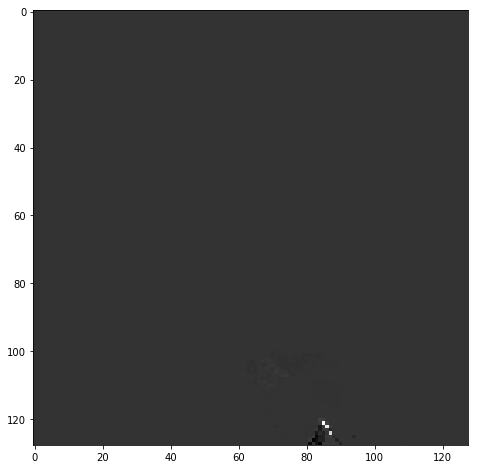

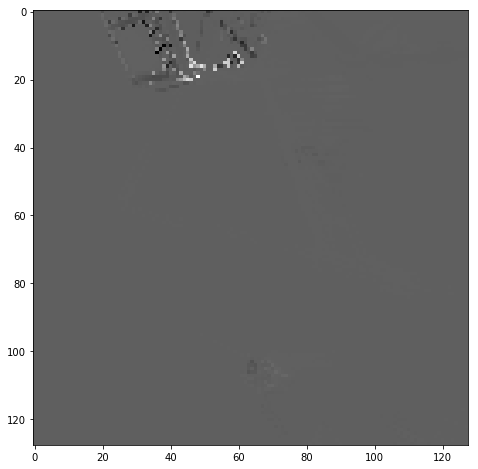

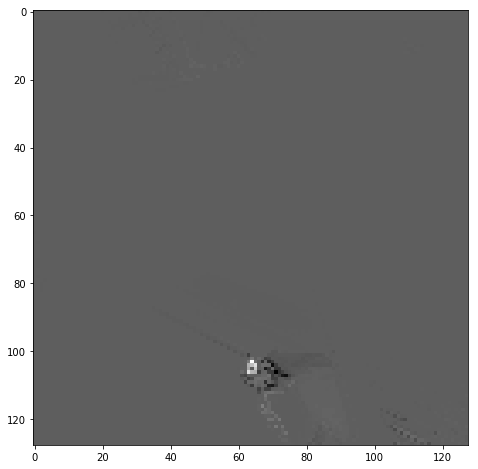

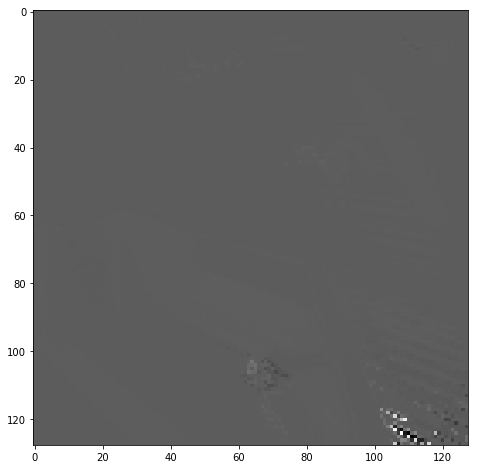

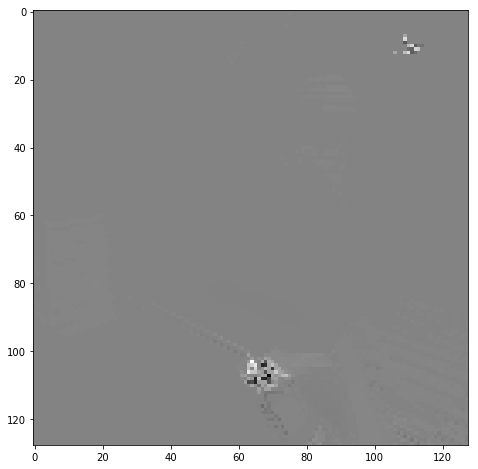

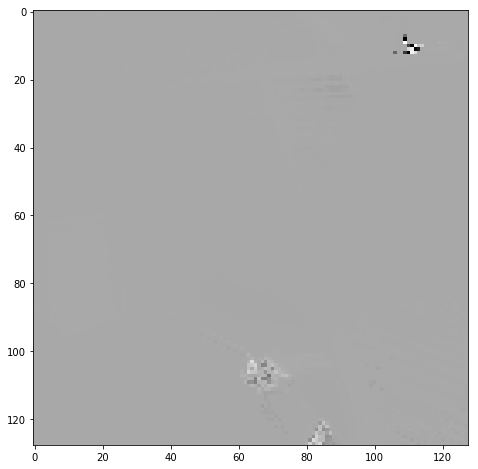

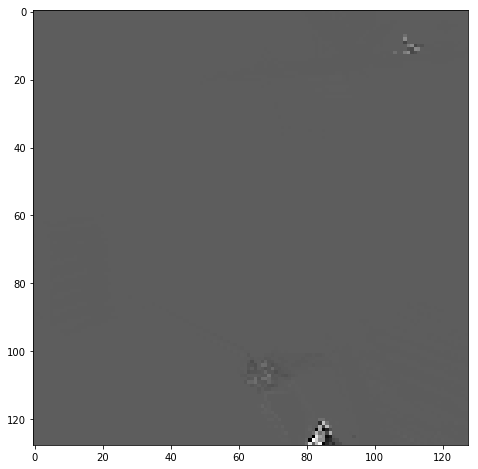

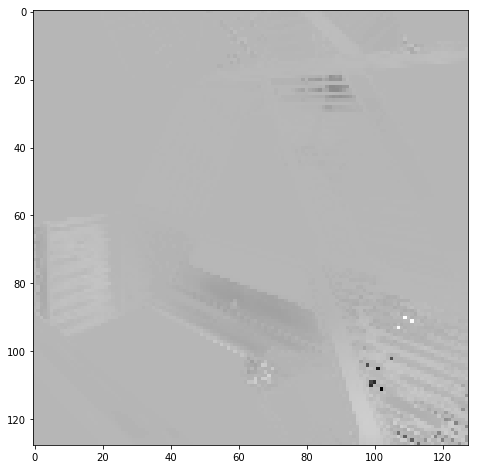

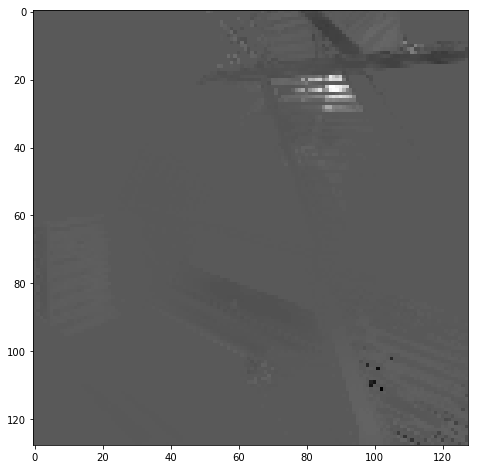

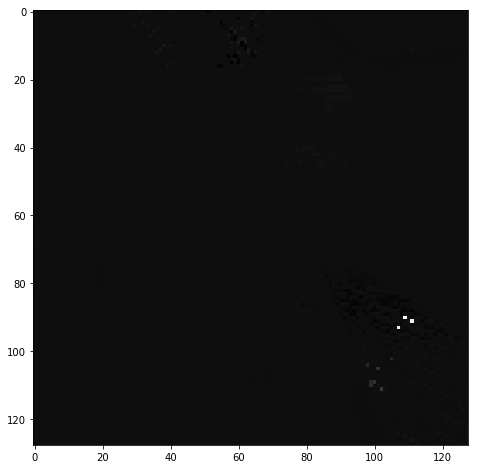

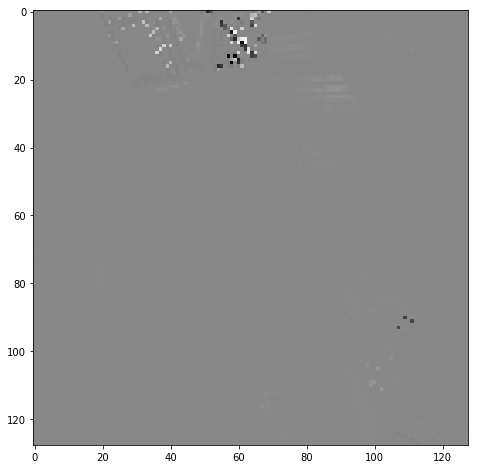

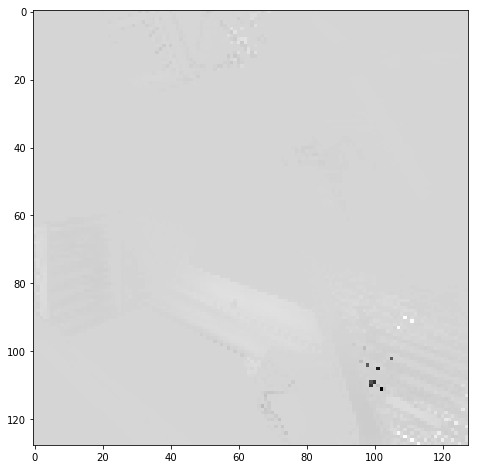

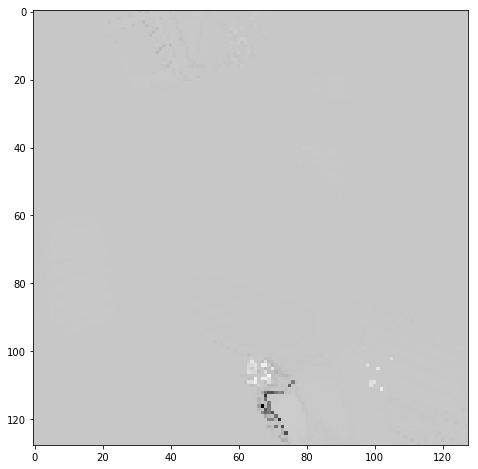

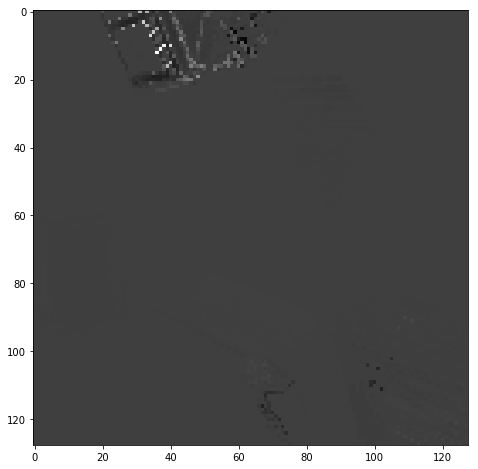

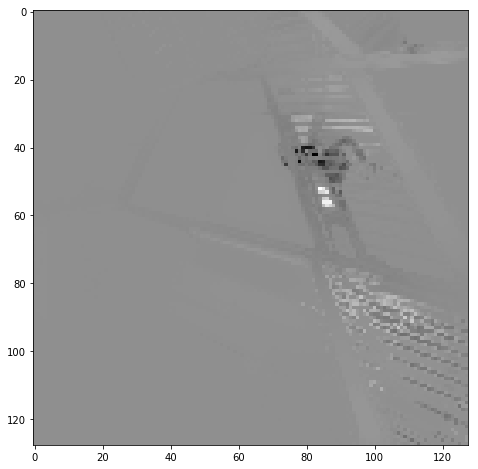

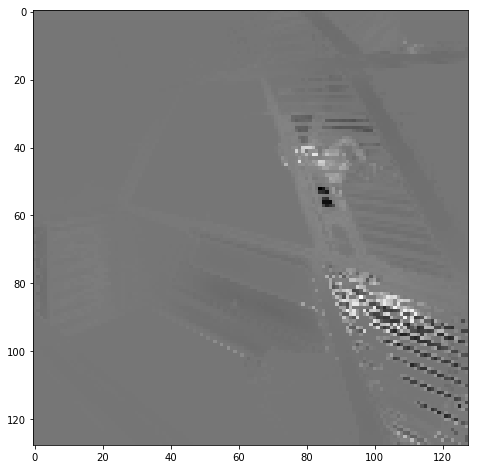

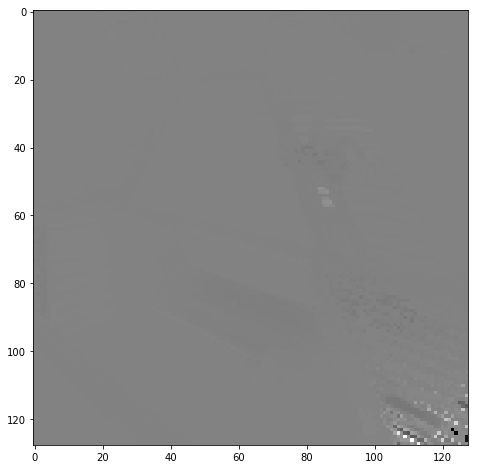

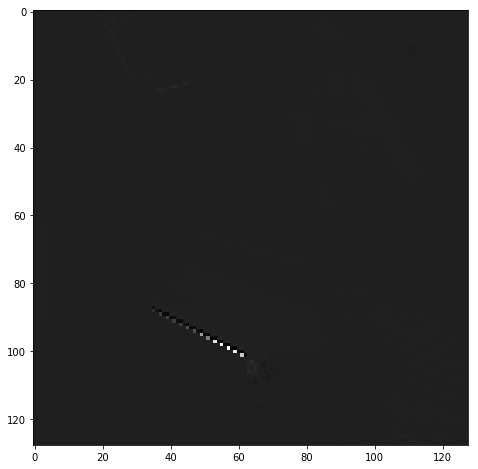

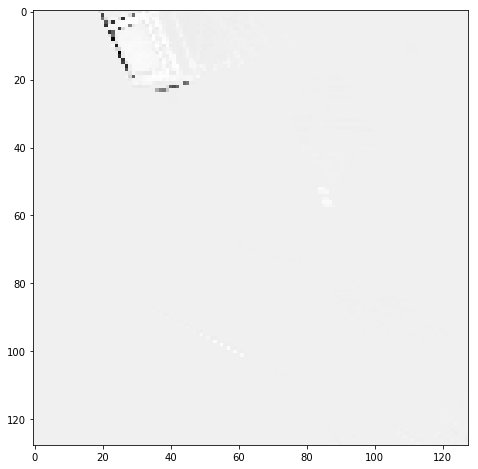

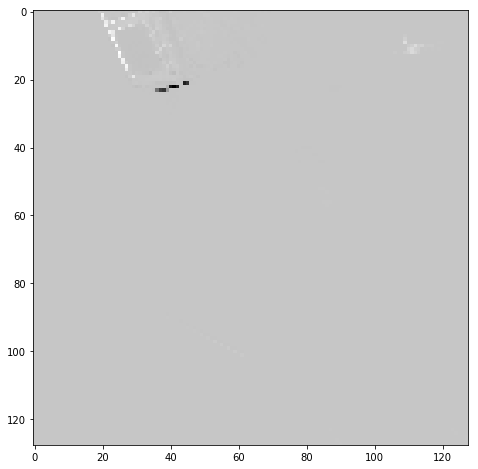

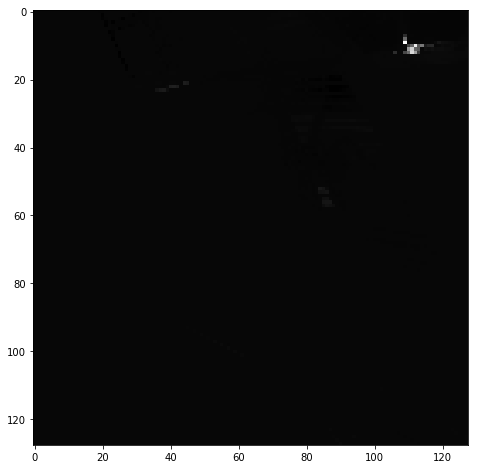

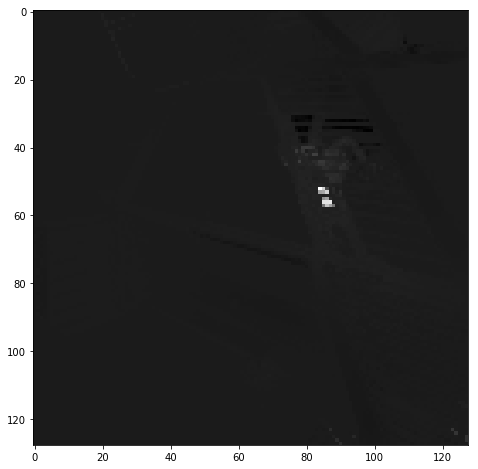

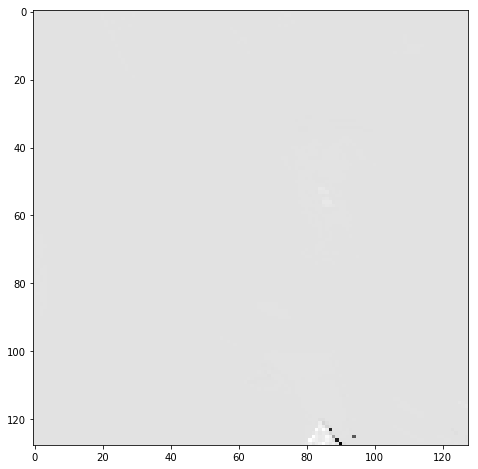

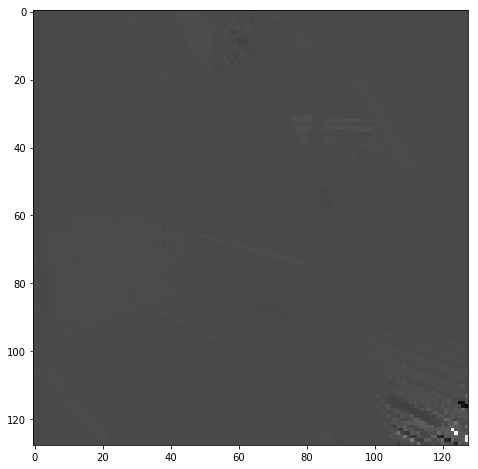

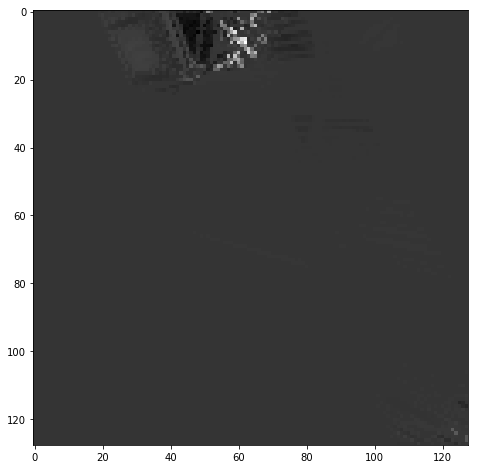

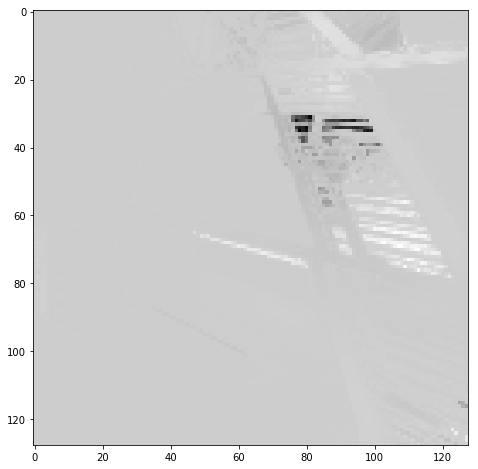

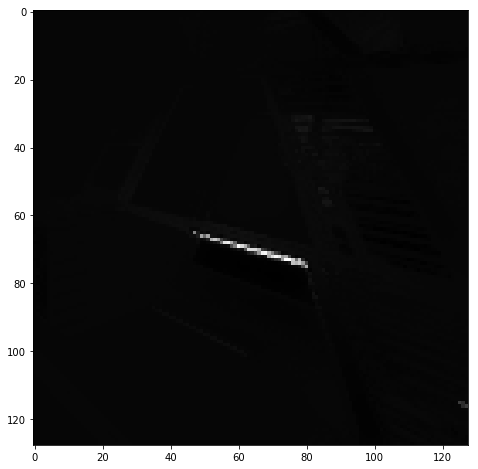

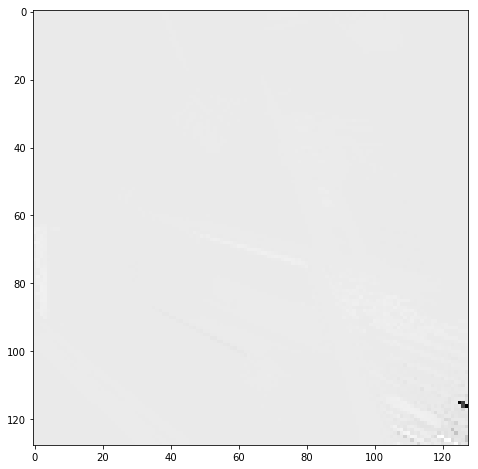

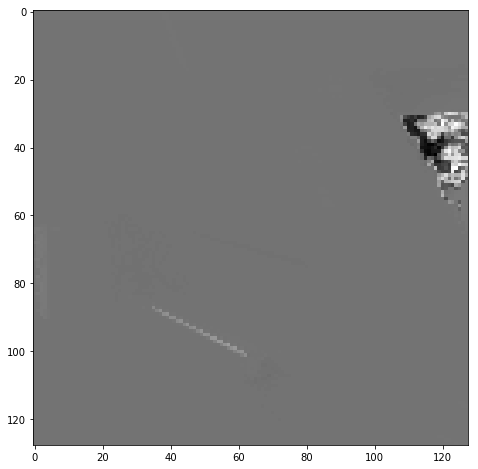

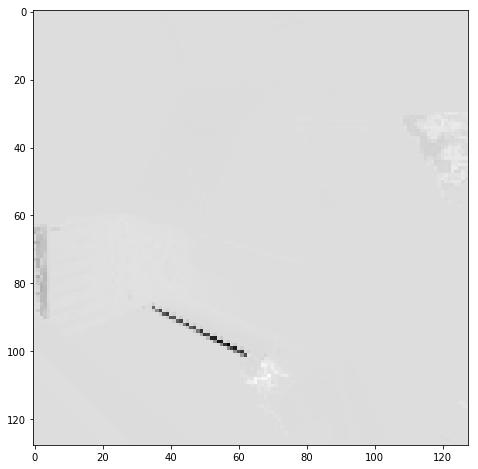

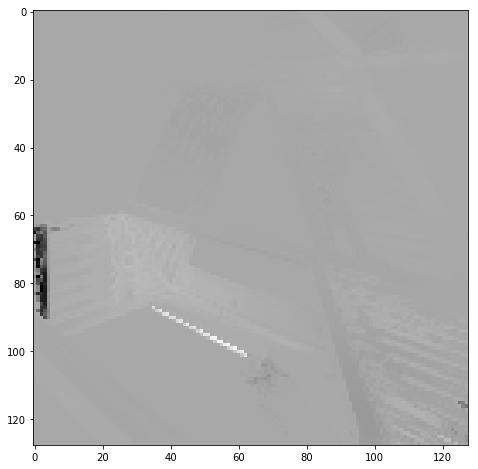

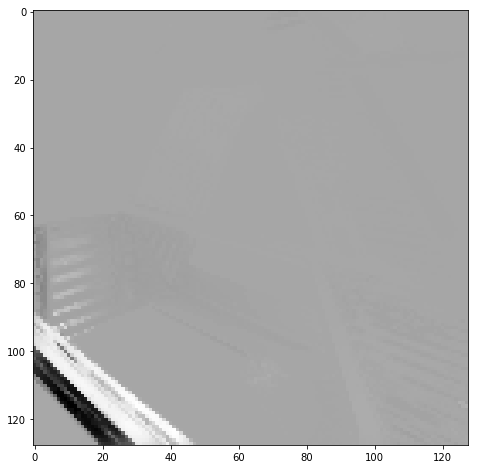

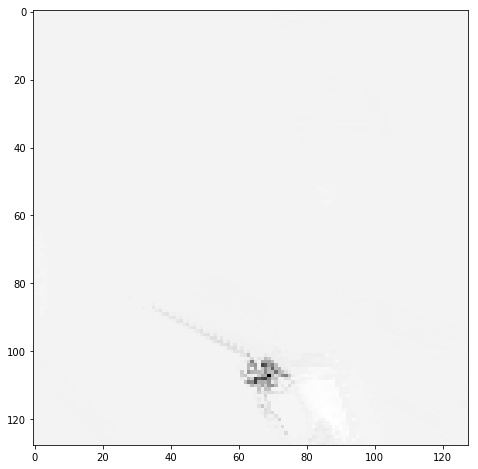

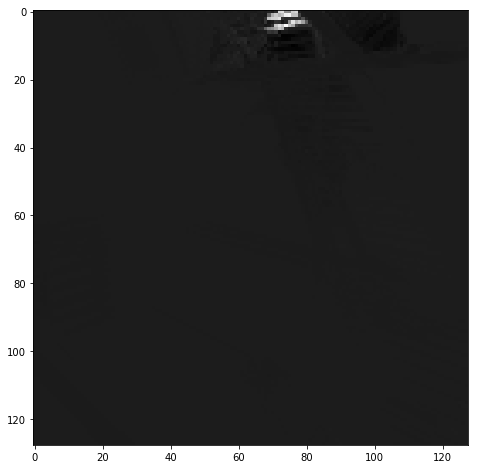

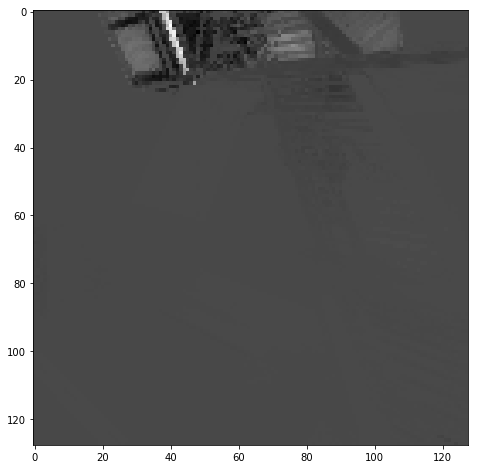

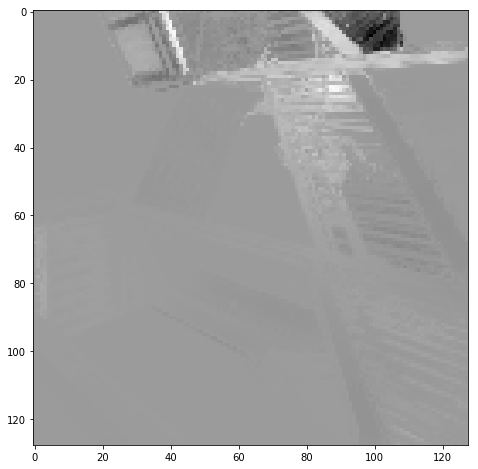

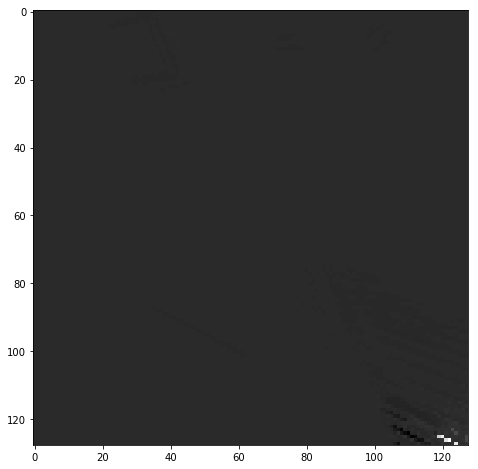

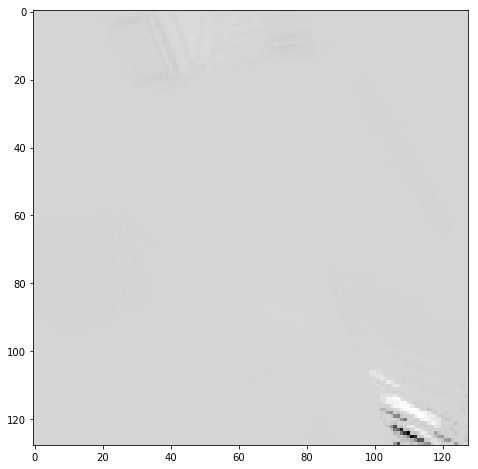

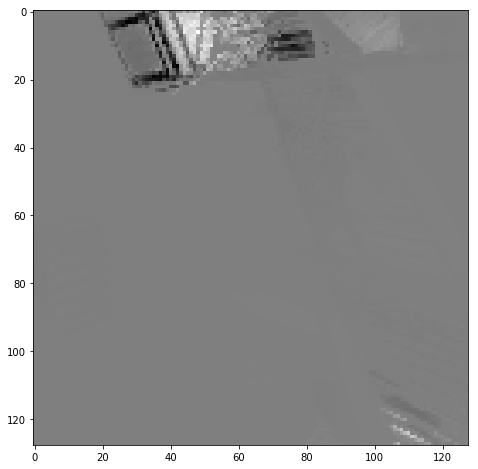

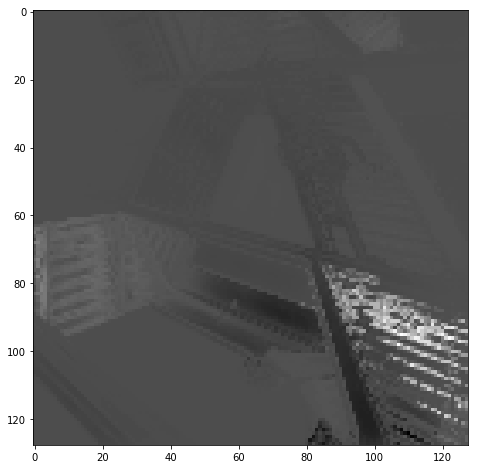

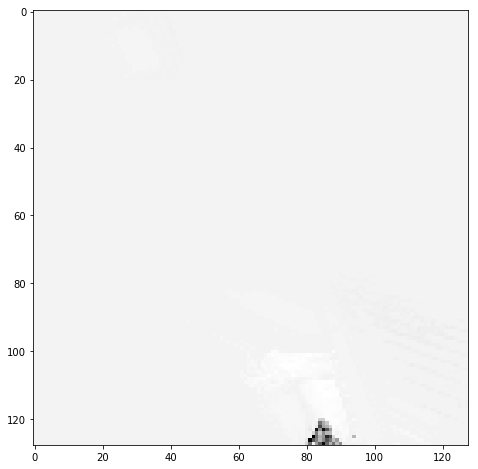

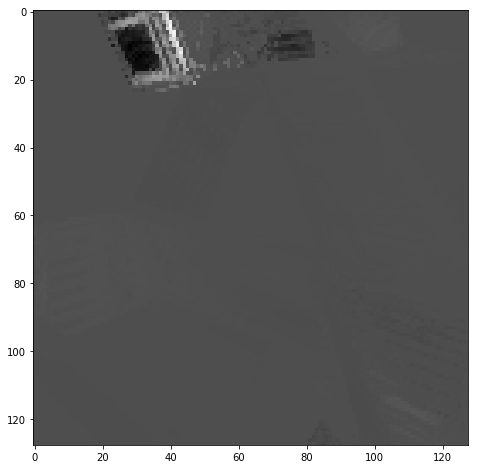

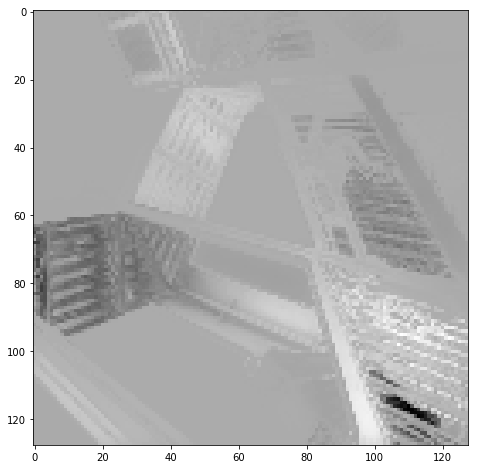

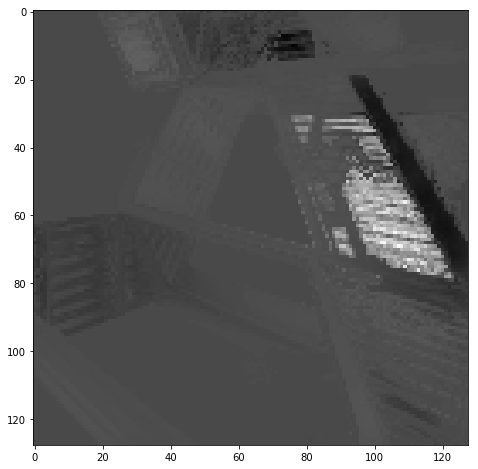

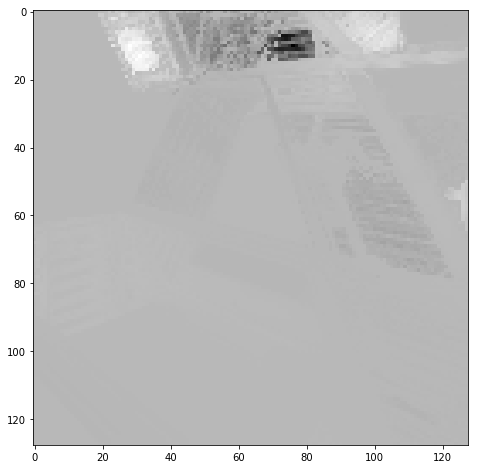

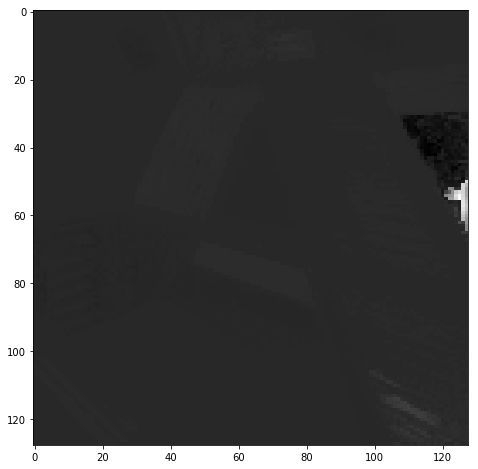

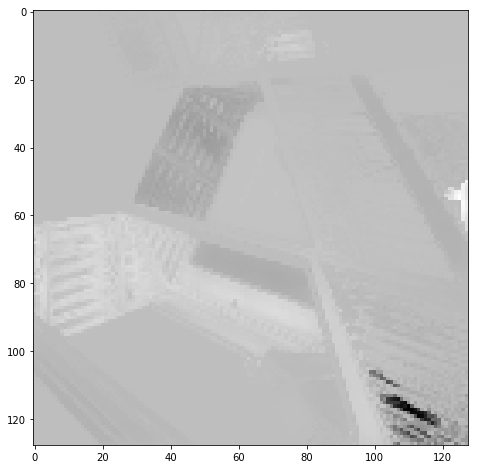

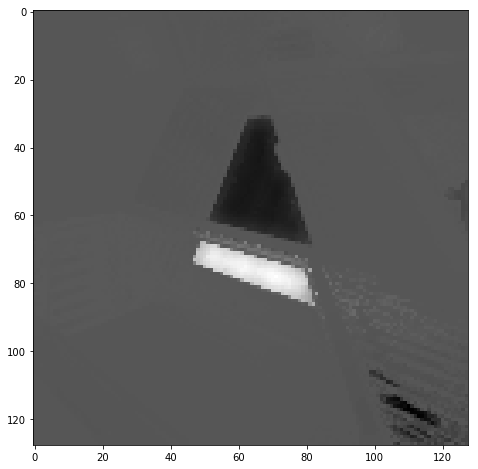

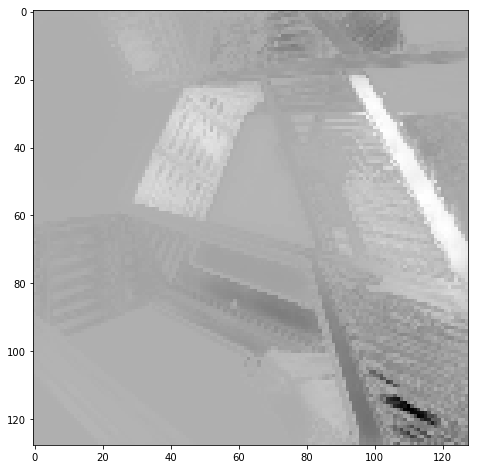

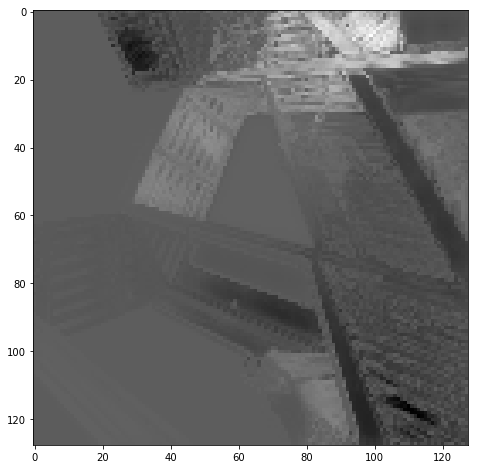

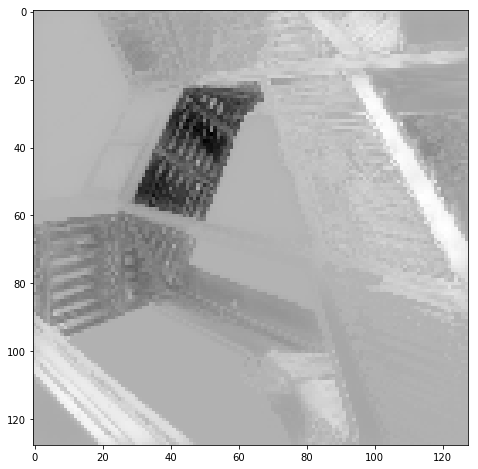

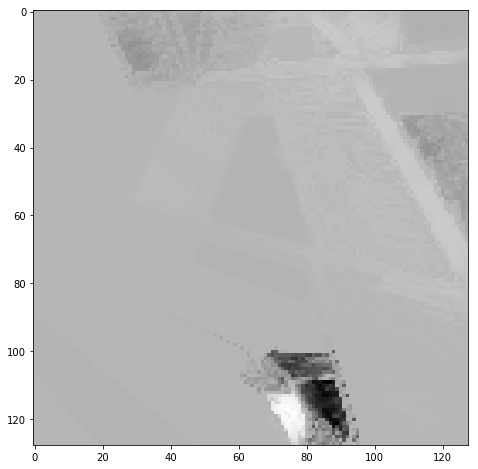

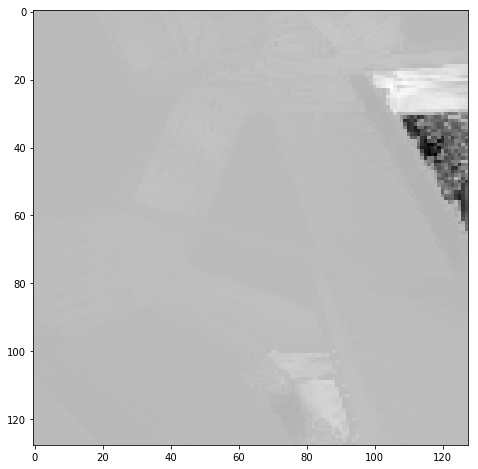

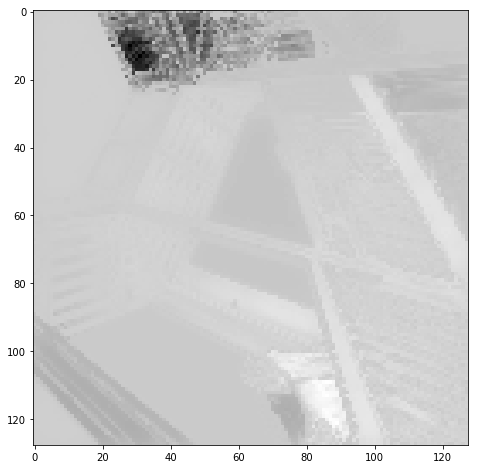

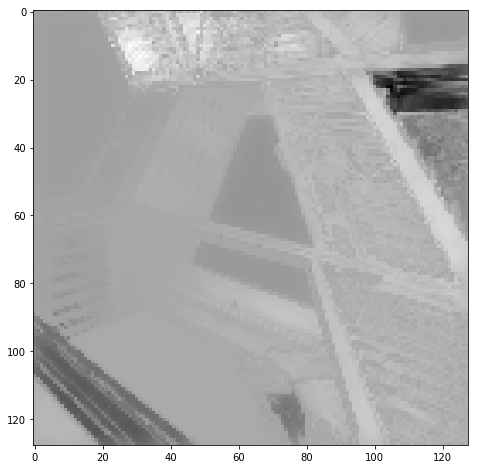

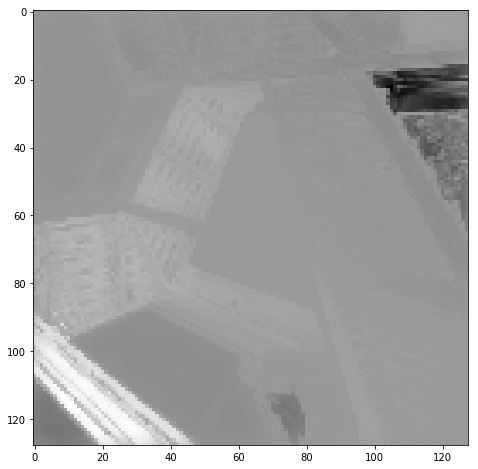

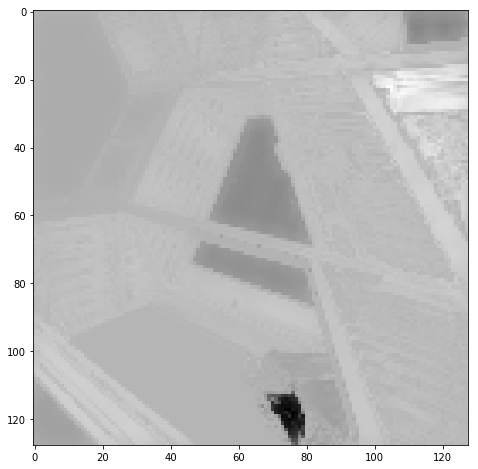

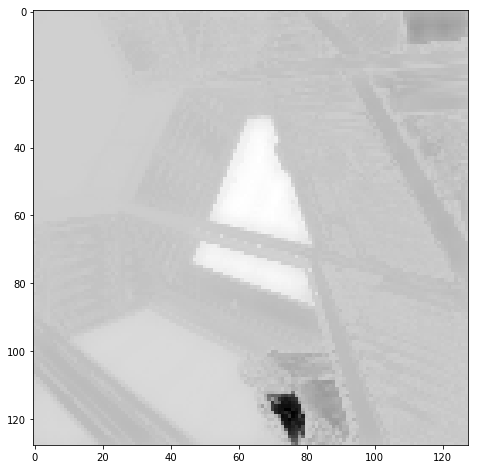

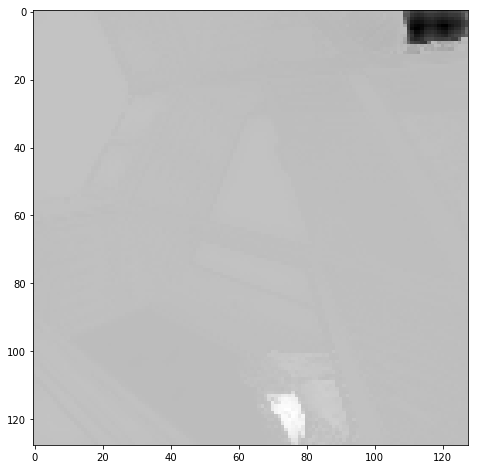

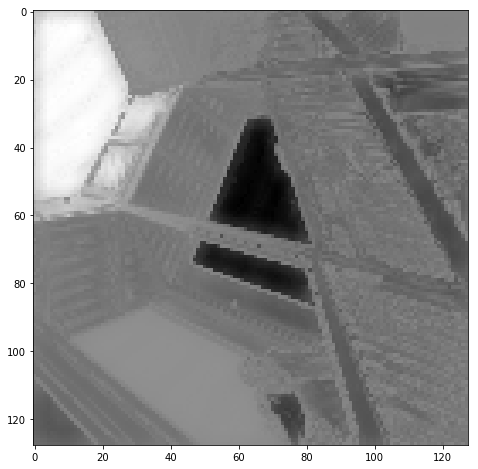

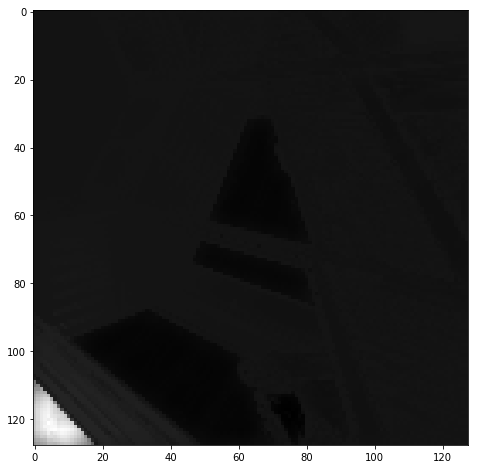

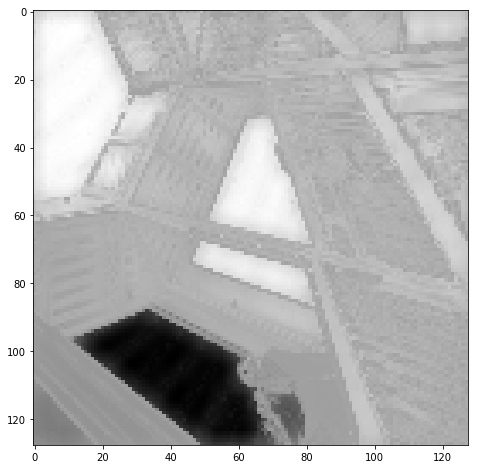

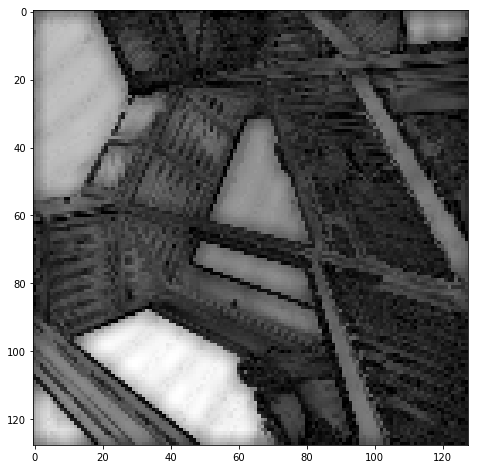

In [59]:

#Norm of each eigenvector
#print("Norm is "+str(np.linalg.norm(X[:,0])))

for i in range(X.shape[1]):
  figure(i)
  imshow(np.reshape(X[:,i],im.shape), interpolation='nearest', cmap=cm.gray)